In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.models import load_model
from scipy.ndimage import label

### Functions for the pipeline:

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
        box1 (tuple): Bounding box 1 (x_min, y_min, x_max, y_max).
        box2 (tuple): Bounding box 2 (x_min, y_min, x_max, y_max).
    
    Returns:
        float: IoU value.
    """
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    # Calculate intersection area
    inter_width = max(0, x_max - x_min)
    inter_height = max(0, y_max - y_min)
    inter_area = inter_width * inter_height

    # Calculate area of both bounding boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = area_box1 + area_box2 - inter_area

    # Compute IoU with better precision
    return round(inter_area / union_area, 6) if union_area > 0 else 0


In [4]:
input_path = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\kaggle challenge\Kaggle Dataset"
output_path = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\Deliverables\task 8\Outputs\output3.csv"
patch_size = 256
example_file_name = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\Deliverables\task 5\michal_232079_unet_model_v3_256px.h5"
model = load_model(example_file_name, custom_objects={"f1": f1})

# Define the example image for visualizations
example_id = "10"  # The ID of the image you want visualized (e.g., "test_image_1.png" -> ID = "1")


---

### Cropping the images

### Debugging:

Processed: test_image_1.png | Cropped Shape: (2707, 2707)
Processed: test_image_10.png | Cropped Shape: (2778, 2778)
Processed: test_image_11.png | Cropped Shape: (2776, 2776)
Processed: test_image_12.png | Cropped Shape: (2788, 2788)
Processed: test_image_13.png | Cropped Shape: (2789, 2789)
Processed: test_image_14.png | Cropped Shape: (2785, 2785)
Processed: test_image_15.png | Cropped Shape: (2787, 2787)
Processed: test_image_16.png | Cropped Shape: (2789, 2789)
Processed: test_image_17.png | Cropped Shape: (2788, 2788)
Processed: test_image_18.png | Cropped Shape: (2788, 2788)
Processed: test_image_2.png | Cropped Shape: (2707, 2707)
Processed: test_image_3.png | Cropped Shape: (2707, 2707)
Processed: test_image_4.png | Cropped Shape: (2707, 2707)
Processed: test_image_5.png | Cropped Shape: (2707, 2707)
Processed: test_image_6.png | Cropped Shape: (2707, 2707)
Processed: test_image_7.png | Cropped Shape: (2707, 2707)
Processed: test_image_8.png | Cropped Shape: (2707, 2707)
Proce

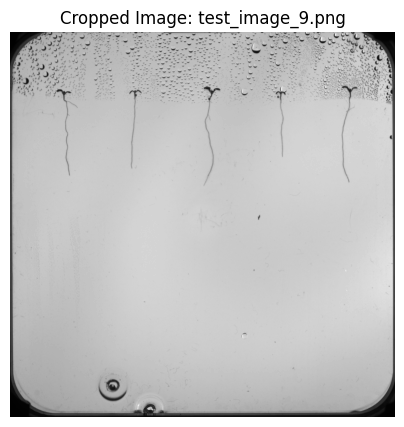

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Threshold for detecting the edge
threshold = 70

def crop_initial(image, initial_crop=100):
    """
    Crops 100 pixels from the left, right, and bottom of the image before applying edge detection.
    """
    return image[:, initial_crop:-initial_crop][:-initial_crop, :]

# Function to find edges by looping through the line
def find_edges(line, threshold):
    left_edge, right_edge = None, None
    n = len(line)

    # Loop from the left to find the first transition
    for i in range(1, n):
        if line[i - 1] < threshold <= line[i] or line[i - 1] >= threshold > line[i]:
            left_edge = i
            break

    # Loop from the right to find the last transition
    for i in range(n - 1, 0, -1):
        if line[i] < threshold <= line[i - 1] or line[i] >= threshold > line[i - 1]:
            right_edge = i
            break

    return left_edge, right_edge

# Function to crop an image based on detected edges
def format(image):
    # Extract horizontal and vertical lines for analysis
    horizontal_line = image[1503, :]  # Pixel values along the middle horizontal line
    vertical_line = image[:, 2056]   # Pixel values along the middle vertical line

    # Find edges along the horizontal and vertical lines
    left_x, right_x = find_edges(horizontal_line, threshold)
    top_y, bottom_y = find_edges(vertical_line, threshold)

    # Ensure the cropped region is square
    side_length = max(right_x - left_x, bottom_y - top_y)
    right_x = left_x + side_length
    bottom_y = top_y + side_length

    return slice(top_y, bottom_y), slice(left_x, right_x)

# Function to process all images in a folder
def process_images(input_path):
    cropped_images = {}

    for file_name in os.listdir(input_path):
        file_path = os.path.join(input_path, file_name)

        # Ensure the file is an image
        if not (file_name.endswith(".png") or file_name.endswith(".jpg") or file_name.endswith(".jpeg")):
            continue

        # Load the image
        original_image = cv2.imread(file_path, 0)  # Load as grayscale

        # Initial crop to remove 100 pixels from left, right, and bottom
        cropped_initial = crop_initial(original_image)

        # Crop the image further using the format function
        crop_slices = format(cropped_initial)
        cropped_image = cropped_initial[crop_slices]

        # Save the cropped image and slices in the dictionary
        cropped_images[file_name] = {
            "cropped_image": cropped_image,
            "crop_slices": crop_slices
        }

        print(f"Processed: {file_name} | Cropped Shape: {cropped_image.shape}")

    return cropped_images

# Example visualization for a specific image
def visualize_cropped_image(cropped_images, example_file_name):
    if example_file_name in cropped_images:
        plt.figure(figsize=(5, 5))
        plt.imshow(cropped_images[example_file_name]["cropped_image"], cmap="gray")
        plt.title(f"Cropped Image: {example_file_name}")
        plt.axis("off")
        plt.show()
    else:
        print(f"Image {example_file_name} not found in processed results.")

# Usage example
cropped_images = process_images(input_path)

# Visualize a specific image
example_file_name = "test_image_9.png"  
visualize_cropped_image(cropped_images, example_file_name)


### Padding the images

Processed test_image_1.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_10.png: Original Shape = (2778, 2778), Padded Shape = (2816, 2816), Padding = (Top: 19, Bottom: 19, Left: 19, Right: 19)
Processed test_image_11.png: Original Shape = (2776, 2776), Padded Shape = (2816, 2816), Padding = (Top: 20, Bottom: 20, Left: 20, Right: 20)
Processed test_image_12.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Processed test_image_13.png: Original Shape = (2789, 2789), Padded Shape = (2816, 2816), Padding = (Top: 13, Bottom: 14, Left: 13, Right: 14)
Processed test_image_14.png: Original Shape = (2785, 2785), Padded Shape = (2816, 2816), Padding = (Top: 15, Bottom: 16, Left: 15, Right: 16)
Processed test_image_15.png: Original Shape = (2787, 2787), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 15, Left: 14, Right: 15)
Visuali

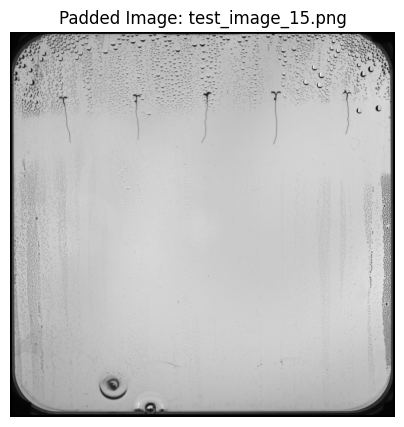

Processed test_image_16.png: Original Shape = (2789, 2789), Padded Shape = (2816, 2816), Padding = (Top: 13, Bottom: 14, Left: 13, Right: 14)
Processed test_image_17.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Processed test_image_18.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Processed test_image_2.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_3.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_4.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_5.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed 

In [6]:
def padder_from_cropped_images(cropped_images, patch_size, example_id=None):
    """
    Adds padding to all cropped images to make their dimensions divisible by a specified patch size.
    Visualizes results for a specified example image ID.

    Parameters:
        cropped_images (dict): A dictionary with image names as keys and values containing:
            - "cropped_image": The cropped image as a NumPy array.
            - "crop_slices": The crop slices used to crop the original image.
        patch_size (int): The size of the patches the image should be divisible by.
        example_id (str): The ID of the image to visualize results for.

    Returns:
        dict: Updated dictionary with padded images and padding values added.
    """
    padded_images = {}

    for file_name, data in cropped_images.items():
        cropped_image = data["cropped_image"]  # Extract the cropped image

        # Get dimensions of the cropped image
        h, w = cropped_image.shape[:2]
        height_padding = ((h // patch_size) + 1) * patch_size - h
        width_padding = ((w // patch_size) + 1) * patch_size - w

        top_padding = height_padding // 2
        bottom_padding = height_padding - top_padding

        left_padding = width_padding // 2
        right_padding = width_padding - left_padding

        # Add padding using cv2.copyMakeBorder
        padded_image = cv2.copyMakeBorder(
            cropped_image,
            top_padding,
            bottom_padding,
            left_padding,
            right_padding,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0]  # Padding with black pixels
        )

        # Update the dictionary with the padded image and padding values
        padded_images[file_name] = {
            "padded_image": padded_image,
            "padding": (top_padding, bottom_padding, left_padding, right_padding),
            "crop_slices": data["crop_slices"]  # Retain the original crop slices
        }

        print(f"Processed {file_name}: Original Shape = {cropped_image.shape}, "
              f"Padded Shape = {padded_image.shape}, "
              f"Padding = (Top: {top_padding}, Bottom: {bottom_padding}, "
              f"Left: {left_padding}, Right: {right_padding})")

        # Visualize only if the current file matches the exact example_id
        example_file_name = f"test_image_{example_id}.png"  # Adjust to match your naming convention
        if example_id and file_name == example_file_name:
            print(f"Visualizing example image: {file_name}")
            plt.figure(figsize=(5, 5))
            plt.imshow(padded_image, cmap="gray")
            plt.title(f"Padded Image: {file_name}")
            plt.axis("off")
            plt.show()

    return padded_images

# Run the padding function
padded_images = padder_from_cropped_images(cropped_images, patch_size, 15)


### Inference:

Processing test_image_1.png...
Completed test_image_1.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_10.png...
Completed test_image_10.png: Predicted Mask Shape = (2778, 2778)
Processing test_image_11.png...
Completed test_image_11.png: Predicted Mask Shape = (2776, 2776)
Processing test_image_12.png...
Completed test_image_12.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_13.png...
Completed test_image_13.png: Predicted Mask Shape = (2789, 2789)
Processing test_image_14.png...
Completed test_image_14.png: Predicted Mask Shape = (2785, 2785)
Processing test_image_15.png...
Completed test_image_15.png: Predicted Mask Shape = (2787, 2787)
Processing test_image_16.png...
Completed test_image_16.png: Predicted Mask Shape = (2789, 2789)
Processing test_image_17.png...
Completed test_image_17.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_18.png...
Completed test_image_18.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_2.png...
C

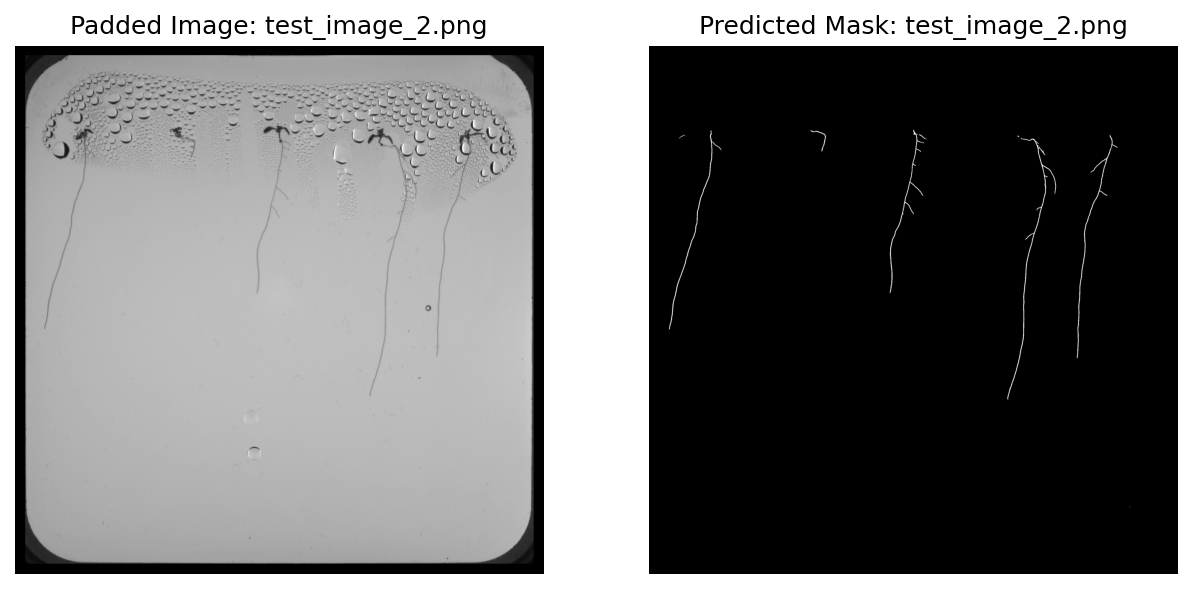

Processing test_image_3.png...
Completed test_image_3.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_4.png...
Completed test_image_4.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_5.png...
Completed test_image_5.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_6.png...
Completed test_image_6.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_7.png...
Completed test_image_7.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_8.png...
Completed test_image_8.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_9.png...
Completed test_image_9.png: Predicted Mask Shape = (2789, 2789)


In [7]:
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt
import os

def run_inference_on_padded_images(padded_images, model, patch_size, example_id=None):
    """
    Runs inference on multiple padded images, predicts masks, and crops them back to original dimensions.
    Visualizes results for a specified example image ID.

    Parameters:
        padded_images (dict): Dictionary containing padded images and their padding details.
        model (keras.Model): Pre-trained model for inference.
        patch_size (int): Size of patches for prediction.
        example_id (str): The exact ID of the image to visualize results for.

    Returns:
        dict: Dictionary with predicted masks and their original dimensions.
    """
    results = {}

    for file_name, data in padded_images.items():
        print(f"Processing {file_name}...")

        padded_image = data["padded_image"]
        padding = data["padding"]
        top_padding, bottom_padding, left_padding, right_padding = padding

        # Convert to 3 channels for patching
        padded_image_3channel = np.repeat(padded_image[..., np.newaxis], 3, axis=-1)

        # Create patches for prediction
        patches = patchify(padded_image_3channel, (patch_size, patch_size, 3), step=patch_size)
        patches_flat = patches.reshape(-1, patch_size, patch_size, 3) / 255.0  # Normalize

        # Predict patches
        predictions = model.predict(patches_flat, verbose=0)  # Run prediction silently
        predicted_patches = (predictions > 0.5).astype(np.uint8)
        predicted_patches_reshaped = predicted_patches.reshape(
            patches.shape[0], patches.shape[1], patch_size, patch_size
        )

        # Reconstruct the predicted mask
        predicted_mask = unpatchify(predicted_patches_reshaped, padded_image.shape[:2])

        # Remove padding
        predicted_mask_cropped = predicted_mask[
            top_padding:predicted_mask.shape[0] - bottom_padding,
            left_padding:predicted_mask.shape[1] - right_padding
        ]

        # Save the result
        results[file_name] = {
            "predicted_mask": predicted_mask_cropped,
            "original_shape": predicted_mask_cropped.shape
        }

        print(f"Completed {file_name}: Predicted Mask Shape = {predicted_mask_cropped.shape}")

        # Visualize only if the current file matches the exact example_id
        example_file_name = f"test_image_{example_id}.png"  # Adjust to match your naming convention
        if example_id and file_name == example_file_name:
            print(f"Visualizing example image: {file_name}")
            f, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
            ax[0].imshow(padded_image, cmap='gray')
            ax[0].axis('off')
            ax[0].set_title(f'Padded Image: {file_name}')
            ax[1].imshow(predicted_mask_cropped, cmap='gray')
            ax[1].axis('off')
            ax[1].set_title(f'Predicted Mask: {file_name}')
            plt.show()


    return results

# Run inference and visualize the specific example image
predicted_results = run_inference_on_padded_images(padded_images, model, patch_size, 2)



### Morphological operations:

In [8]:
import cv2
import numpy as np

def apply_closing_to_all(predicted_results, kernel_size):
    """
    Apply morphological closing to all predicted masks and store the results in a compatible format.

    Parameters:
        predicted_results (dict): Dictionary with predicted masks and metadata.
        kernel_size (tuple): Size of the structuring element.

    Returns:
        dict: Dictionary with IDs as keys and processed masks in the required structure.
    """
    closed_masks = {}
    kernel = np.ones(kernel_size, np.uint8)  # Structuring element

    for file_name, data in predicted_results.items():
        print(f"Processing mask for {file_name}...")

        # Extract the predicted mask
        mask = data.get("predicted_mask")
        if mask is None:
            raise ValueError(f"No predicted mask found for {file_name}.")

        # Apply morphological closing
        closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Store the closed mask in the compatible structure
        closed_masks[file_name] = {"predicted_mask": closed_mask}

    return closed_masks


# Define the kernel size for morphological closing
kernel_size = (31, 31)

# Apply closing to `predicted_results`
closed_masks = apply_closing_to_all(predicted_results, kernel_size)


Processing mask for test_image_1.png...
Processing mask for test_image_10.png...
Processing mask for test_image_11.png...
Processing mask for test_image_12.png...
Processing mask for test_image_13.png...
Processing mask for test_image_14.png...
Processing mask for test_image_15.png...
Processing mask for test_image_16.png...
Processing mask for test_image_17.png...
Processing mask for test_image_18.png...
Processing mask for test_image_2.png...
Processing mask for test_image_3.png...
Processing mask for test_image_4.png...
Processing mask for test_image_5.png...
Processing mask for test_image_6.png...
Processing mask for test_image_7.png...
Processing mask for test_image_8.png...
Processing mask for test_image_9.png...


Processing mask for test_image_1.png...
Visualizing small object removal per section for test_image_1.png


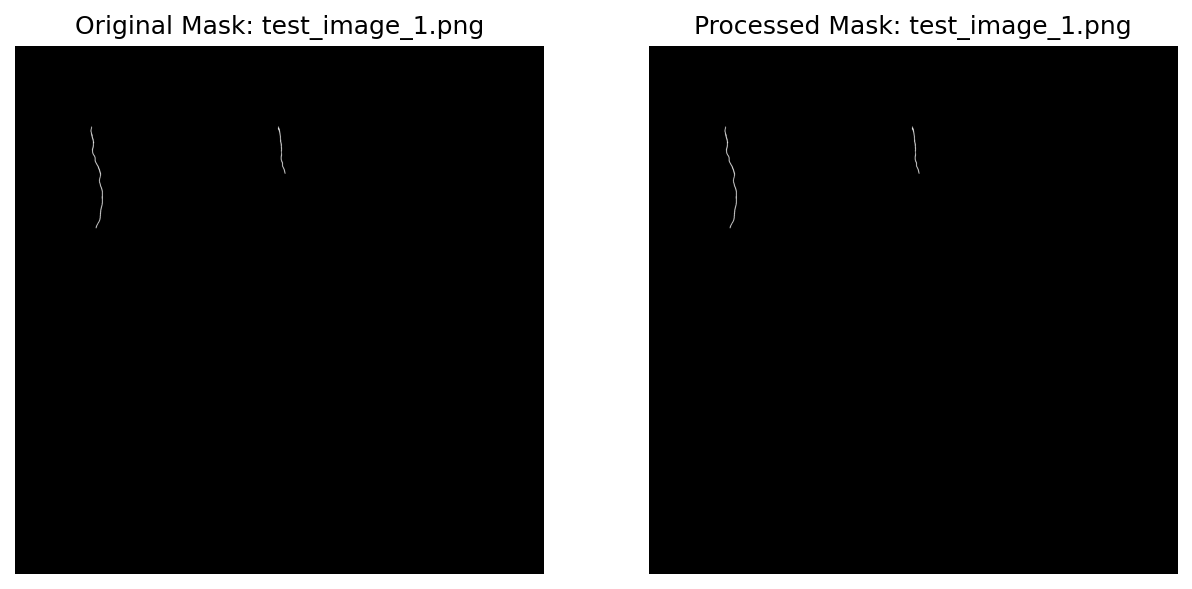

Processing mask for test_image_10.png...
Visualizing small object removal per section for test_image_10.png


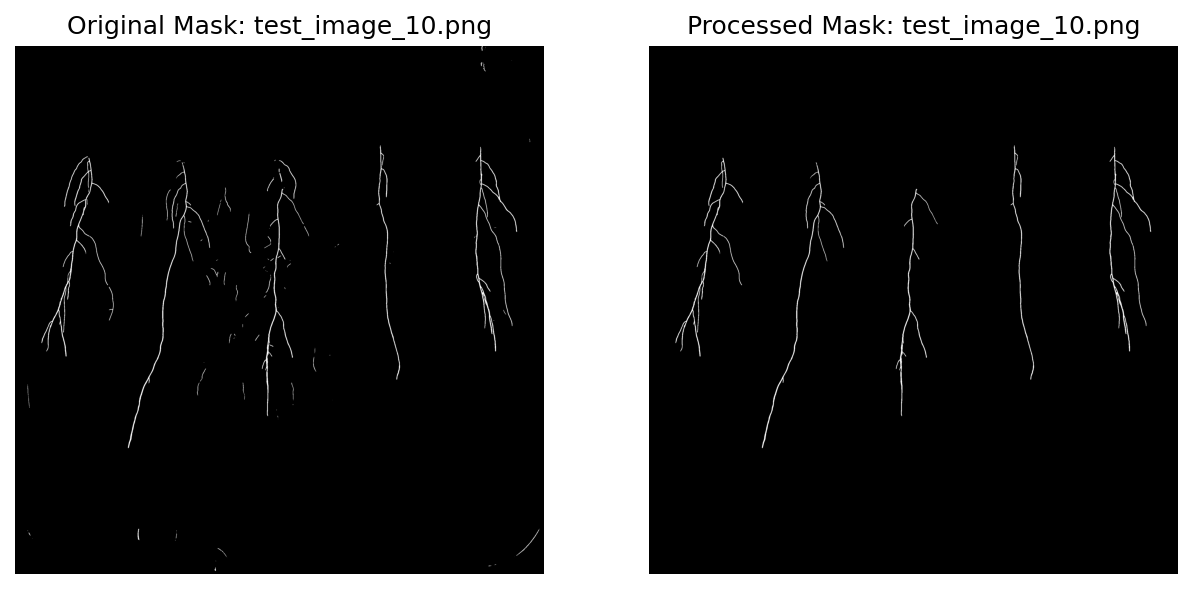

Processing mask for test_image_11.png...
Visualizing small object removal per section for test_image_11.png


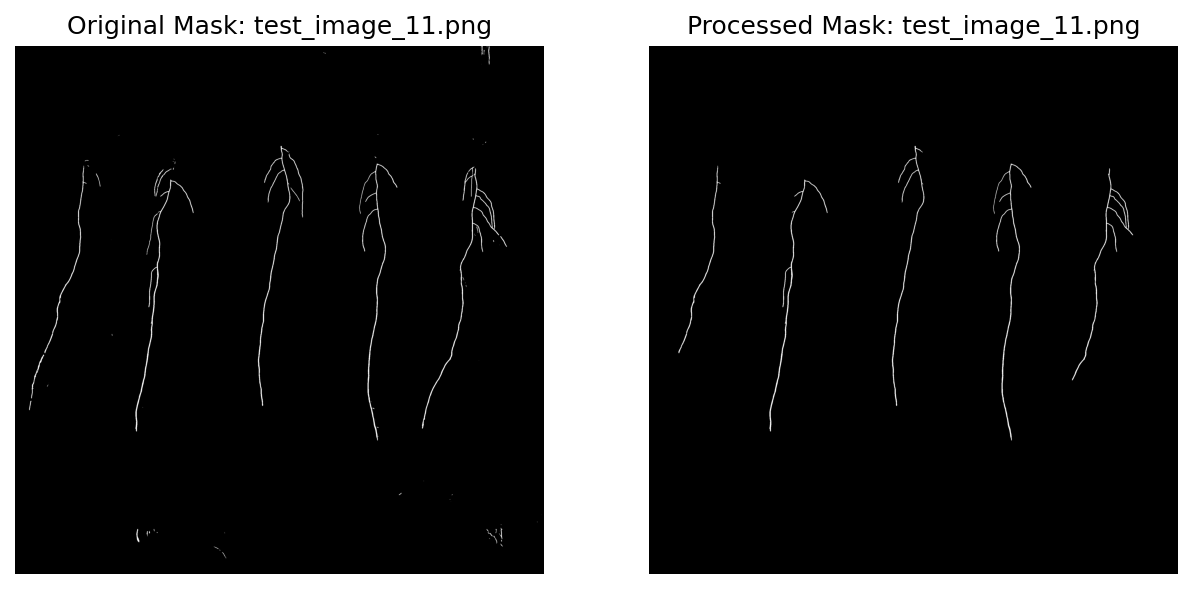

Processing mask for test_image_12.png...
Visualizing small object removal per section for test_image_12.png


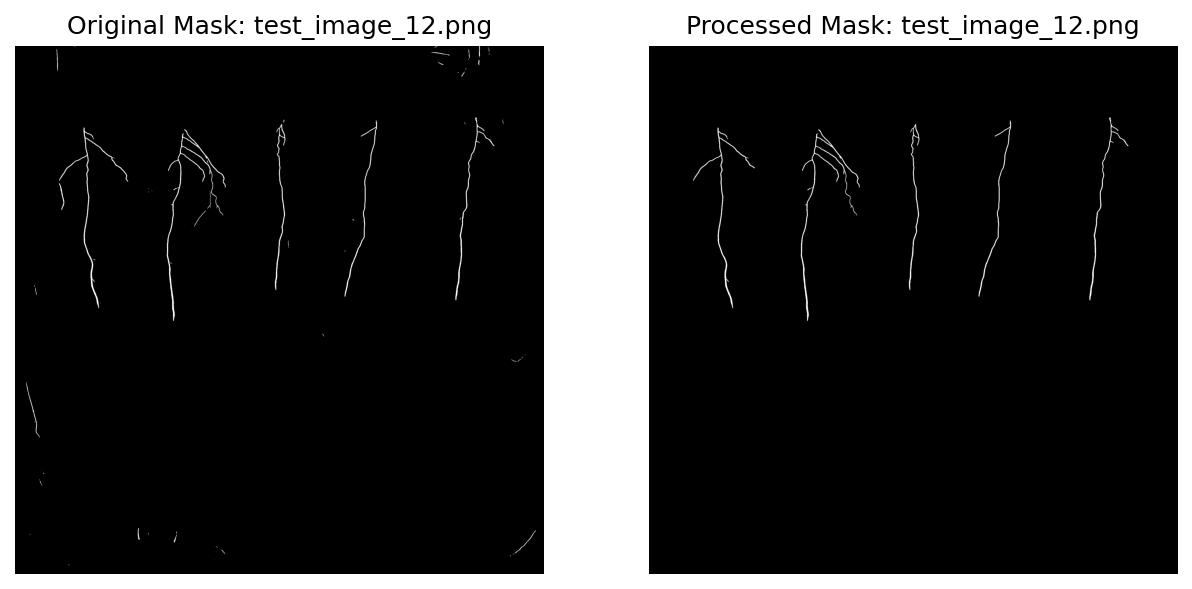

Processing mask for test_image_13.png...
Visualizing small object removal per section for test_image_13.png


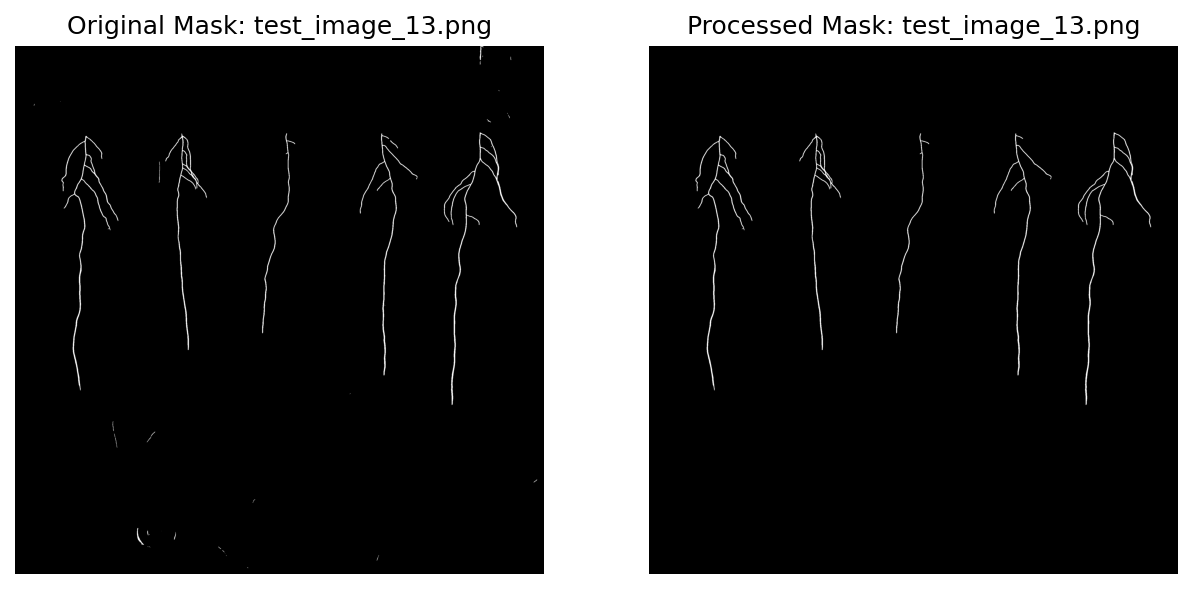

Processing mask for test_image_14.png...
Visualizing small object removal per section for test_image_14.png


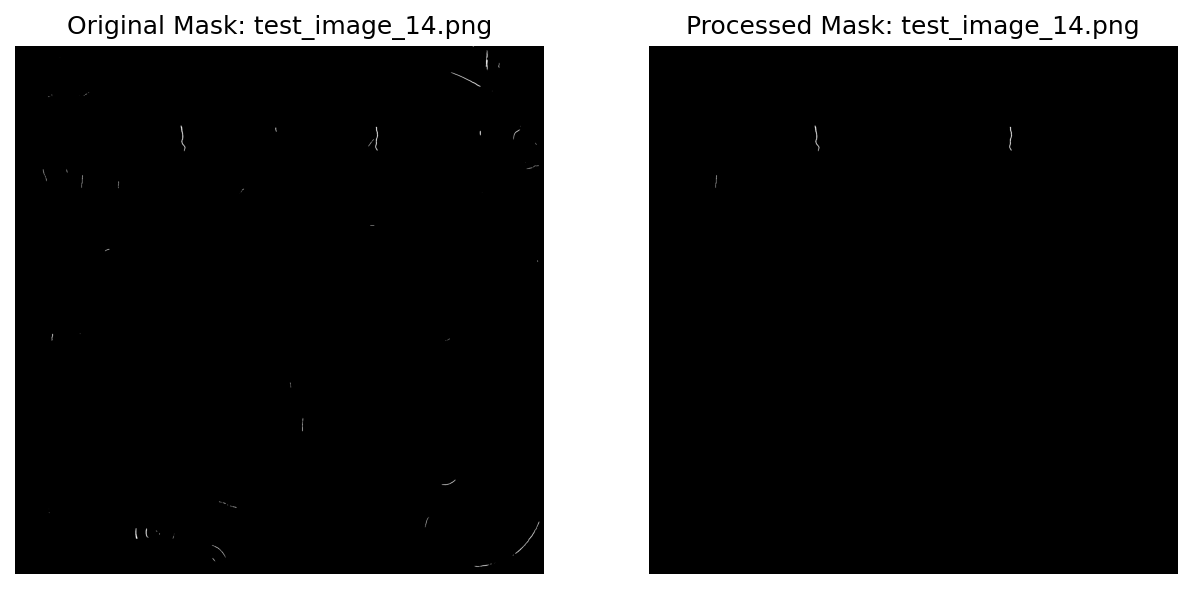

Processing mask for test_image_15.png...
Visualizing small object removal per section for test_image_15.png


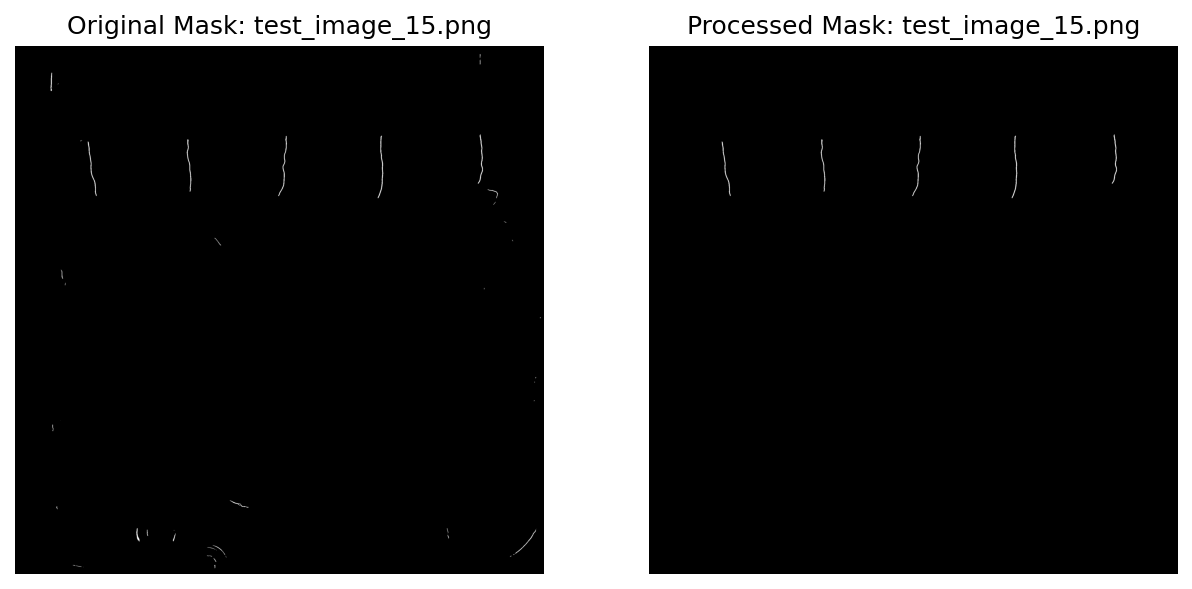

Processing mask for test_image_16.png...
Visualizing small object removal per section for test_image_16.png


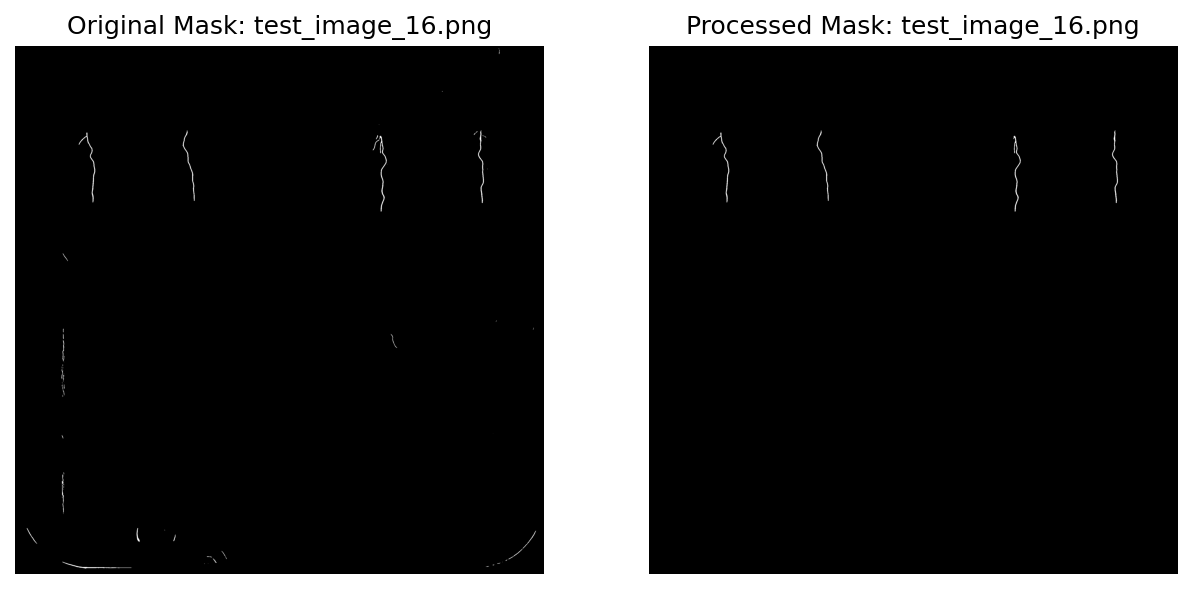

Processing mask for test_image_17.png...
Visualizing small object removal per section for test_image_17.png


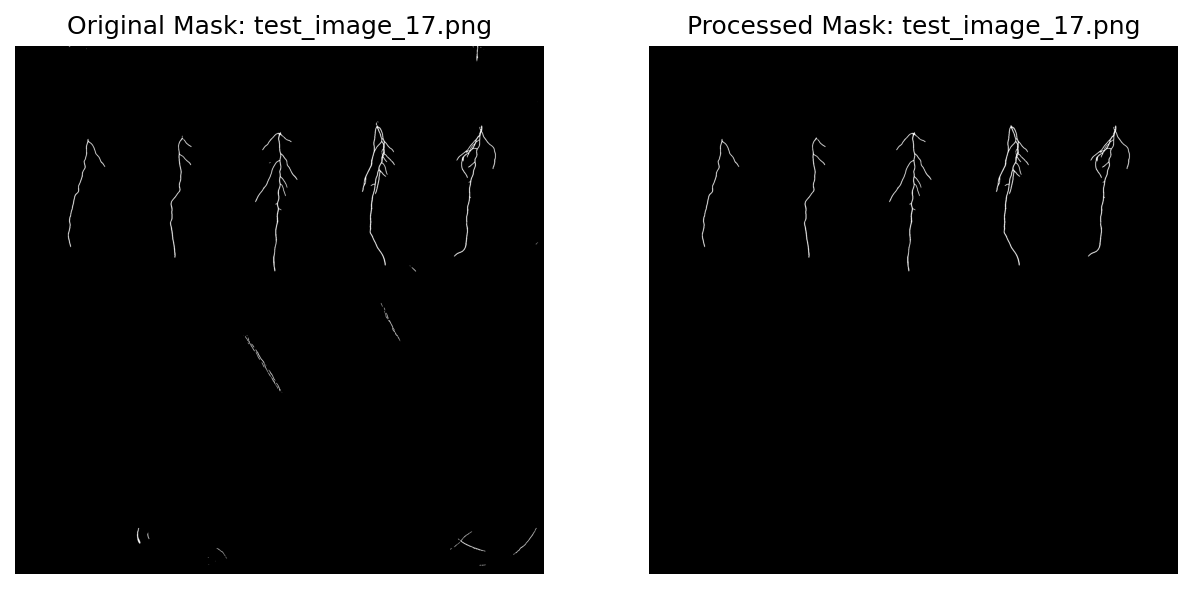

Processing mask for test_image_18.png...
Visualizing small object removal per section for test_image_18.png


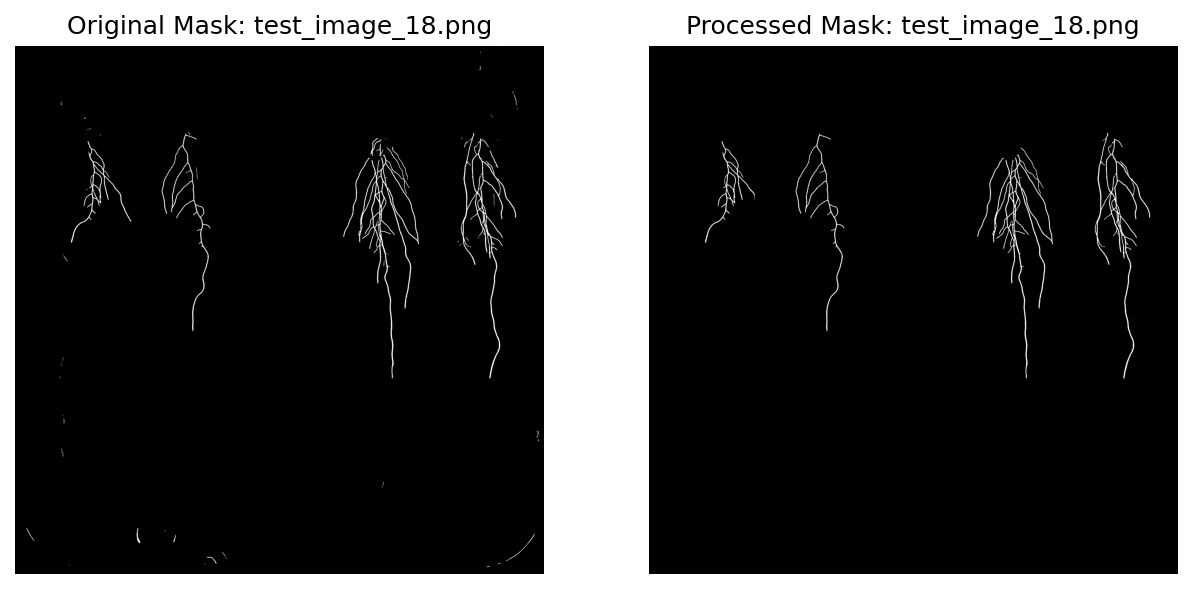

Processing mask for test_image_2.png...
Visualizing small object removal per section for test_image_2.png


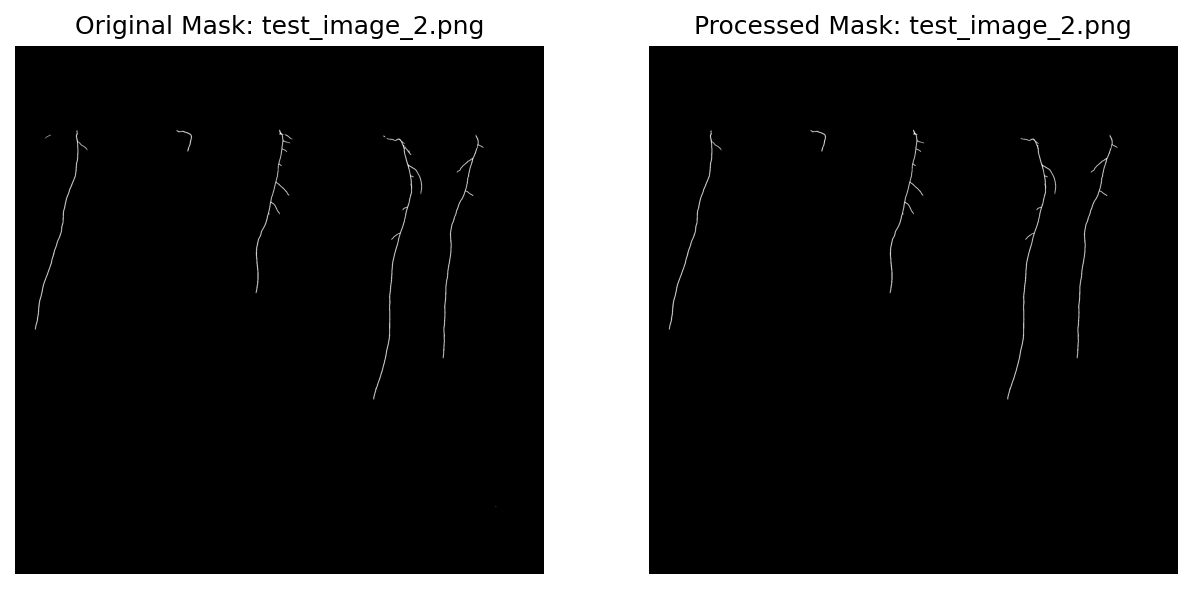

Processing mask for test_image_3.png...
Visualizing small object removal per section for test_image_3.png


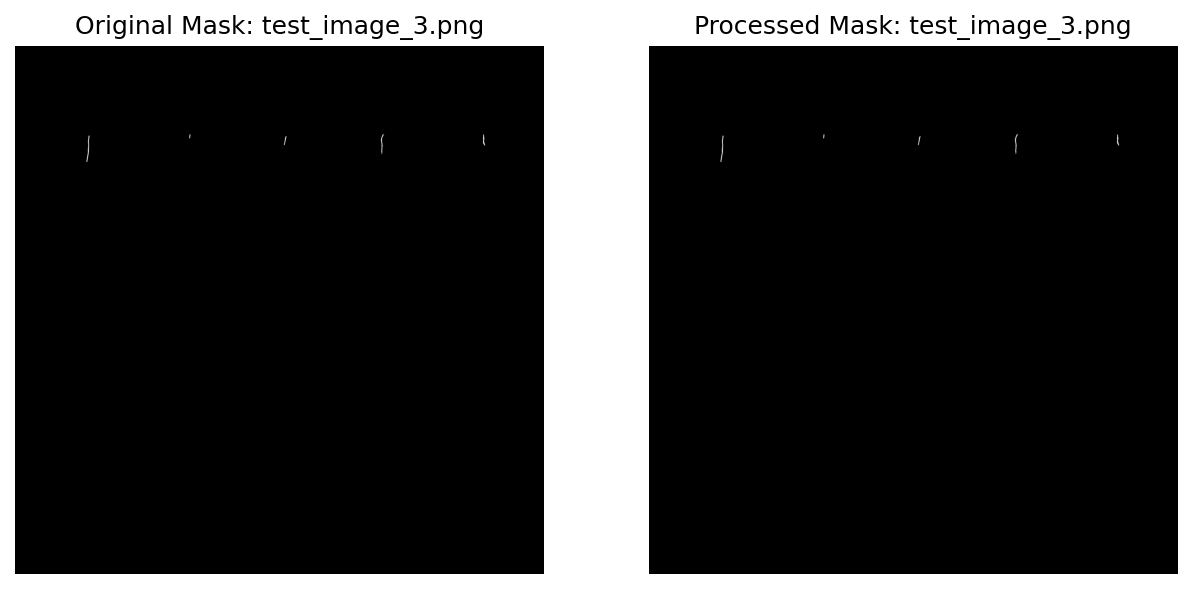

Processing mask for test_image_4.png...
Visualizing small object removal per section for test_image_4.png


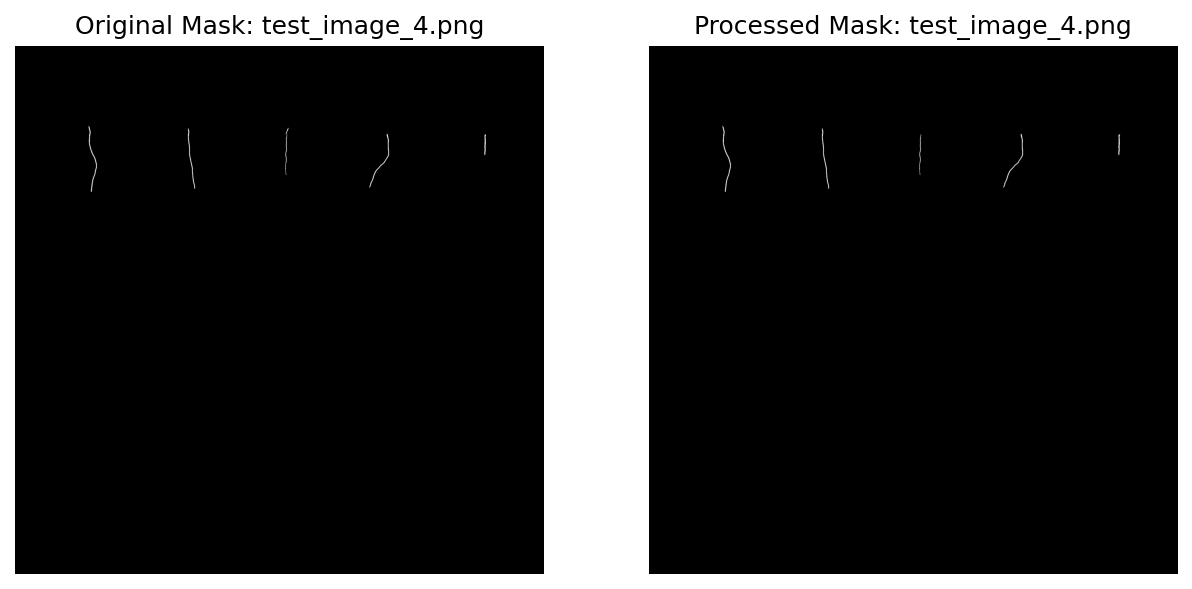

Processing mask for test_image_5.png...
Visualizing small object removal per section for test_image_5.png


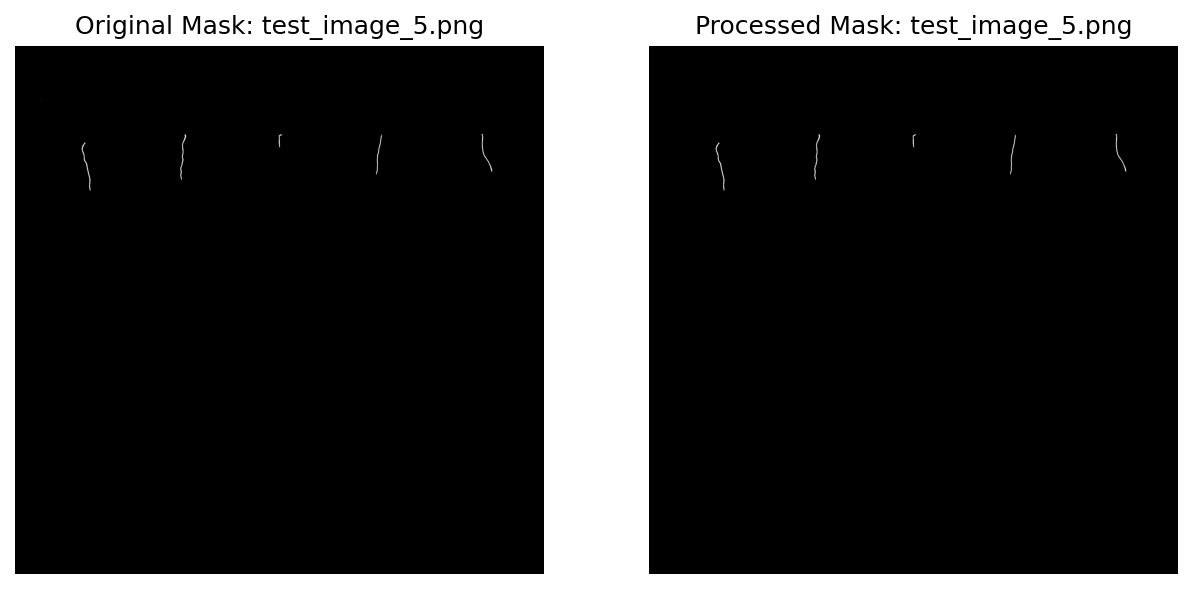

Processing mask for test_image_6.png...
Visualizing small object removal per section for test_image_6.png


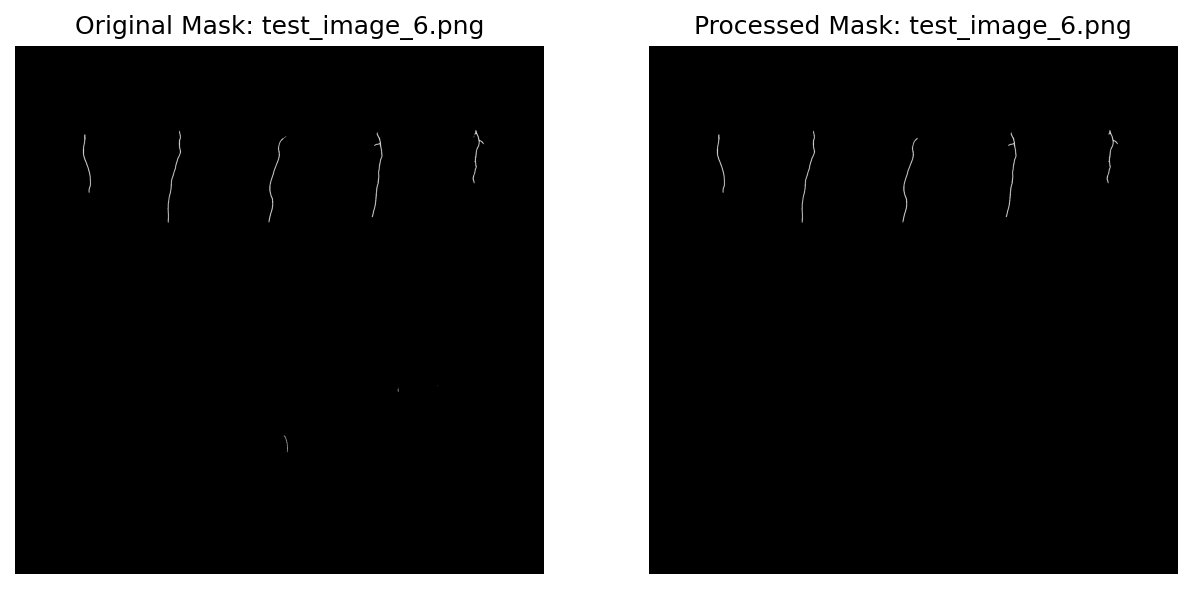

Processing mask for test_image_7.png...
Visualizing small object removal per section for test_image_7.png


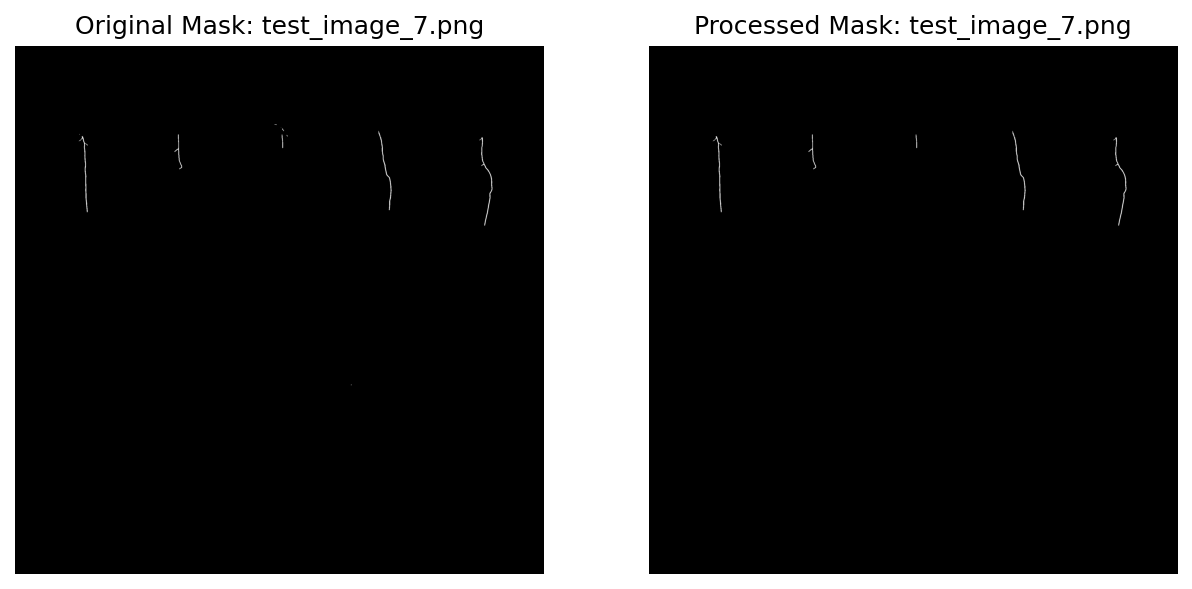

Processing mask for test_image_8.png...
Visualizing small object removal per section for test_image_8.png


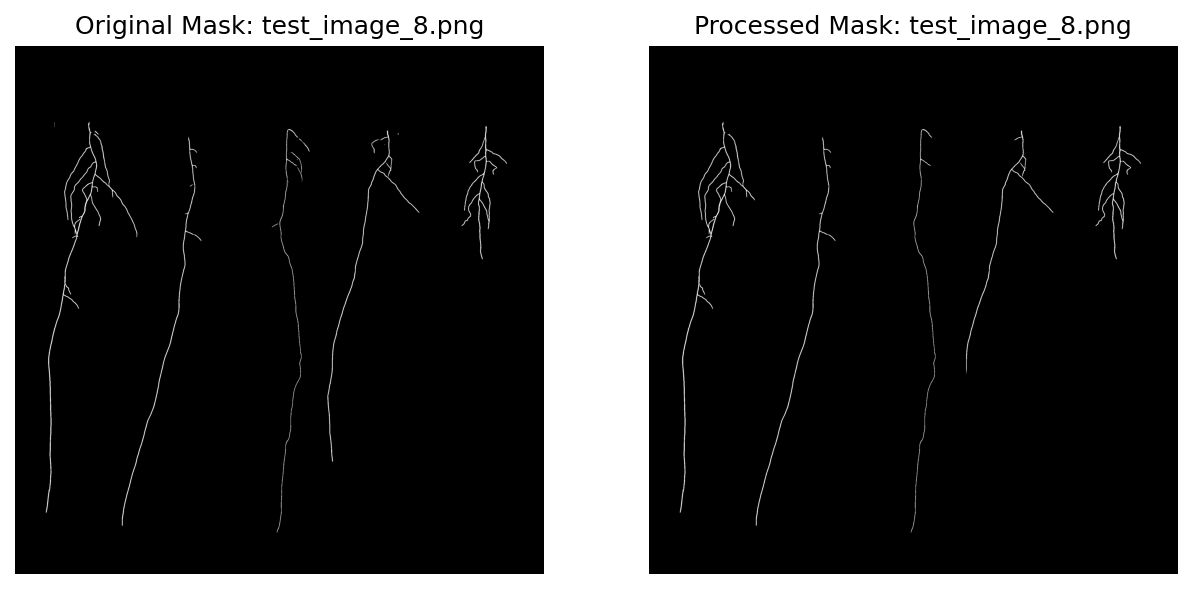

Processing mask for test_image_9.png...
Visualizing small object removal per section for test_image_9.png


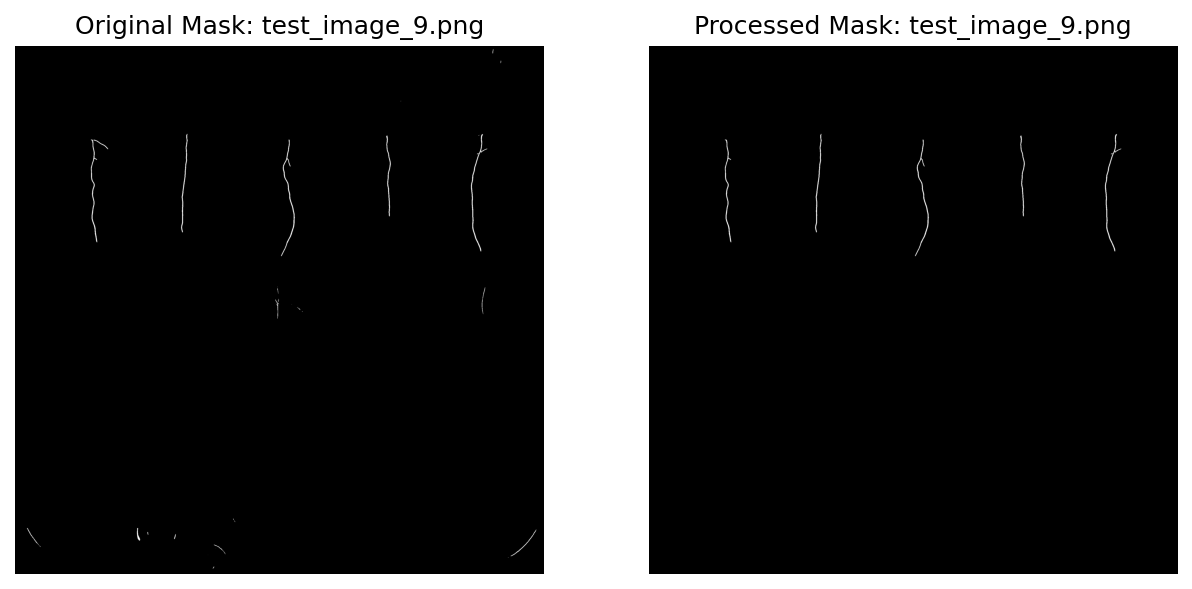

In [23]:
from skimage import morphology
import matplotlib.pyplot as plt
import numpy as np

def apply_remove_small_objects_per_section_with_top_constraint(predicted_results, size_threshold, top_y_threshold, num_sections=5):
    """
    Remove small connected components for each vertical section of the masks, retaining the largest
    component in each section unless it fails both conditions: being below the size threshold and 
    having its top above the y-threshold. Visualizes masks before and after processing.

    Parameters:
        predicted_results (dict): Dictionary with predicted masks and metadata.
        size_threshold (int): Minimum size of components to keep.
        top_y_threshold (int): Maximum y-coordinate for the top of a component to be kept.
        num_sections (int): Number of vertical sections to divide the mask into.

    Returns:
        dict: Dictionary with IDs as keys and processed masks as values.
    """
    processed_masks = {}

    for file_name, data in predicted_results.items():
        print(f"Processing mask for {file_name}...")

        # Extract the predicted mask
        mask = data.get("predicted_mask")
        if mask is None:
            raise ValueError(f"No predicted mask found for {file_name}.")

        # Initialize a blank mask to store results
        h, w = mask.shape
        section_width = w // num_sections
        processed_mask = np.zeros_like(mask, dtype=np.uint8)

        # Process each vertical section
        for i in range(num_sections):
            # Extract the section of the mask
            section_mask = mask[:, i * section_width:(i + 1) * section_width]

            # Label connected components in the section
            labeled_section, num_labels = morphology.label(section_mask > 0, connectivity=2, return_num=True)

            # Calculate sizes and topmost y-coordinates of connected components
            component_info = []
            for label in range(1, num_labels + 1):
                component = (labeled_section == label)
                size = component.sum()
                top_y = np.min(np.where(component)[0]) if size > 0 else None
                component_info.append((label, size, top_y))

            # Find the largest component
            largest_component_label = max(component_info, key=lambda x: x[1])[0] if component_info else None

            # Retain components based on size, top_y, or if it is the largest
            for label, size, top_y in component_info:
                if (
                    (size >= size_threshold or label == largest_component_label)  # Pass size or largest check
                    and (top_y is not None and top_y < top_y_threshold)  # Pass top y constraint
                ):
                    processed_mask[:, i * section_width:(i + 1) * section_width][labeled_section == label] = 255

        processed_masks[file_name] = processed_mask

        # Visualize the original and filtered mask for every image
        print(f"Visualizing small object removal per section for {file_name}")
        f, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
        ax[0].imshow(mask, cmap='gray')
        ax[0].axis('off')
        ax[0].set_title(f'Original Mask: {file_name}')
        ax[1].imshow(processed_mask, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title(f'Processed Mask: {file_name}')
        plt.show()

    return processed_masks


# Define the size threshold, top_y_threshold, and number of sections
size_threshold = 2000
top_y_threshold = 1000  # Adjust this threshold manually
num_sections = 5

# Apply removal per section with top constraint and retain the largest component
processed_masks = apply_remove_small_objects_per_section_with_top_constraint(predicted_results, size_threshold, top_y_threshold, num_sections)


Processing mask for test_image_1.png...
Visualizing mask filtering for test_image_1.png


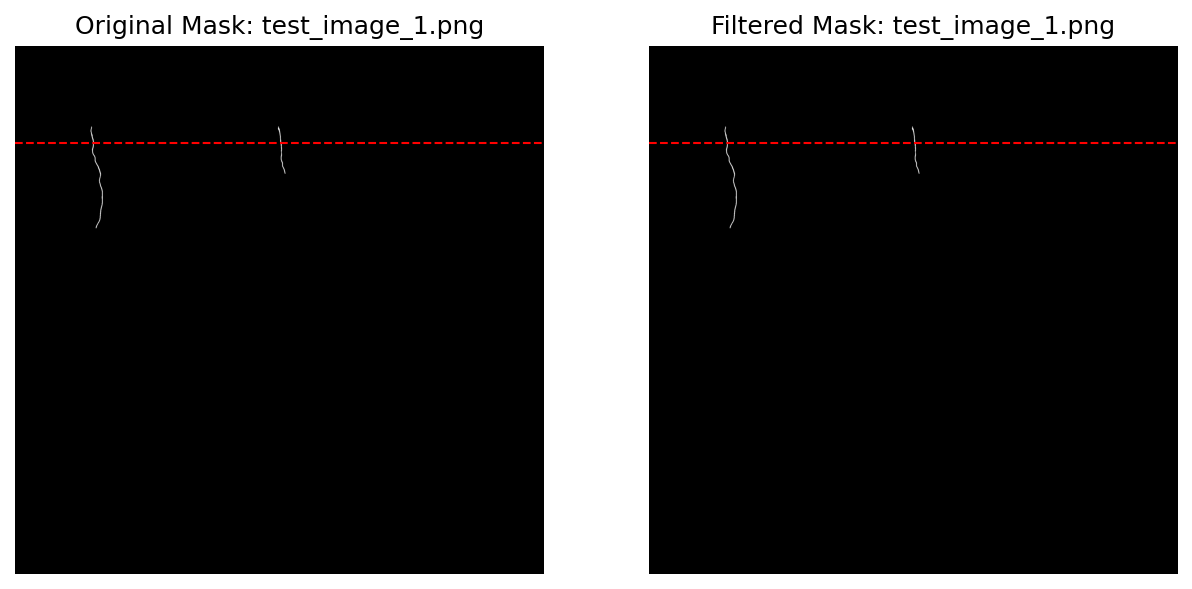

Processing mask for test_image_10.png...
Visualizing mask filtering for test_image_10.png


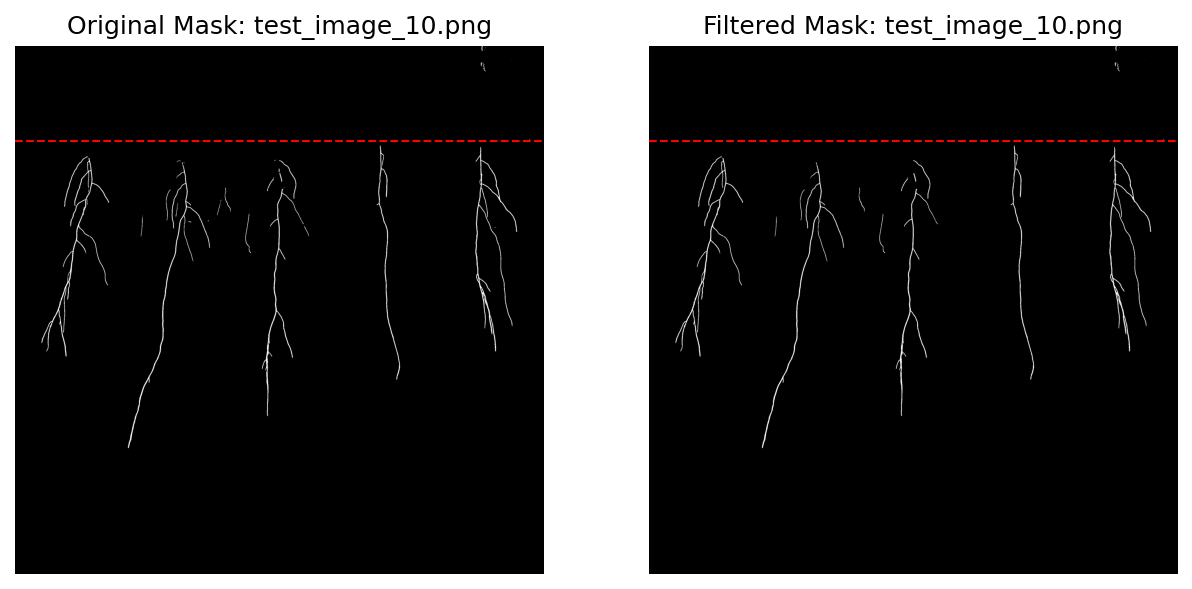

Processing mask for test_image_11.png...
Visualizing mask filtering for test_image_11.png


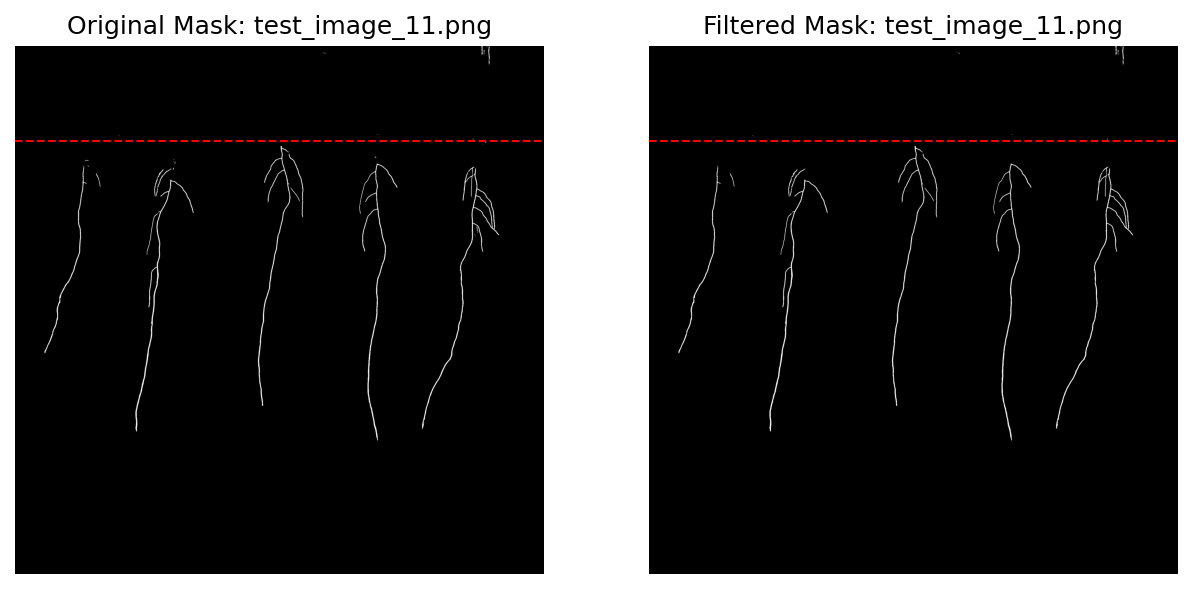

Processing mask for test_image_12.png...
Visualizing mask filtering for test_image_12.png


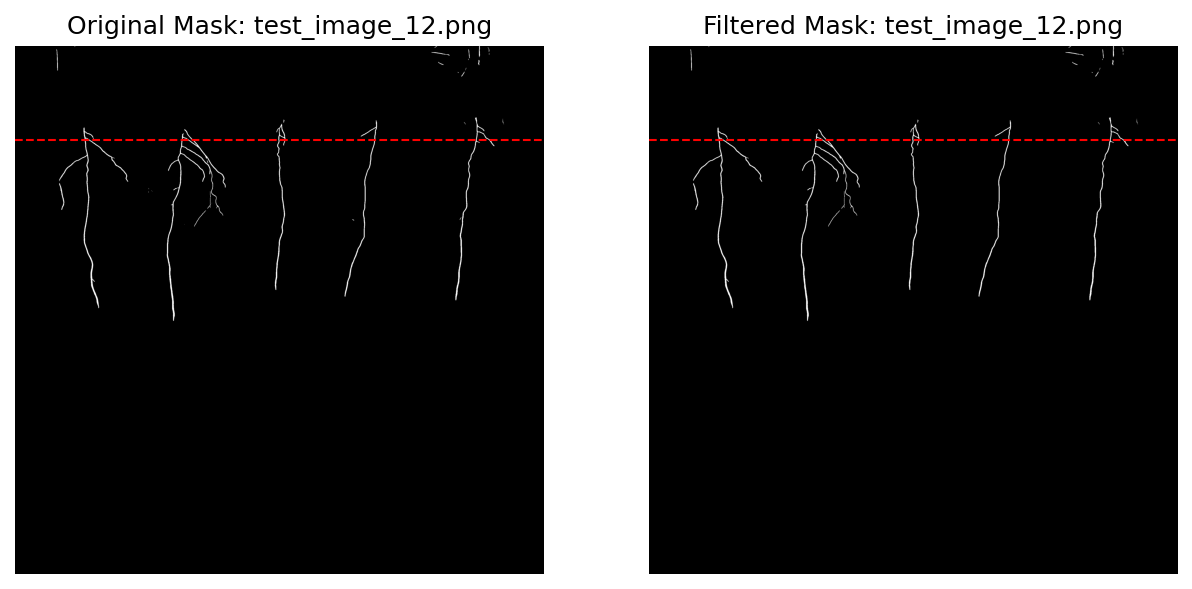

Processing mask for test_image_13.png...
Visualizing mask filtering for test_image_13.png


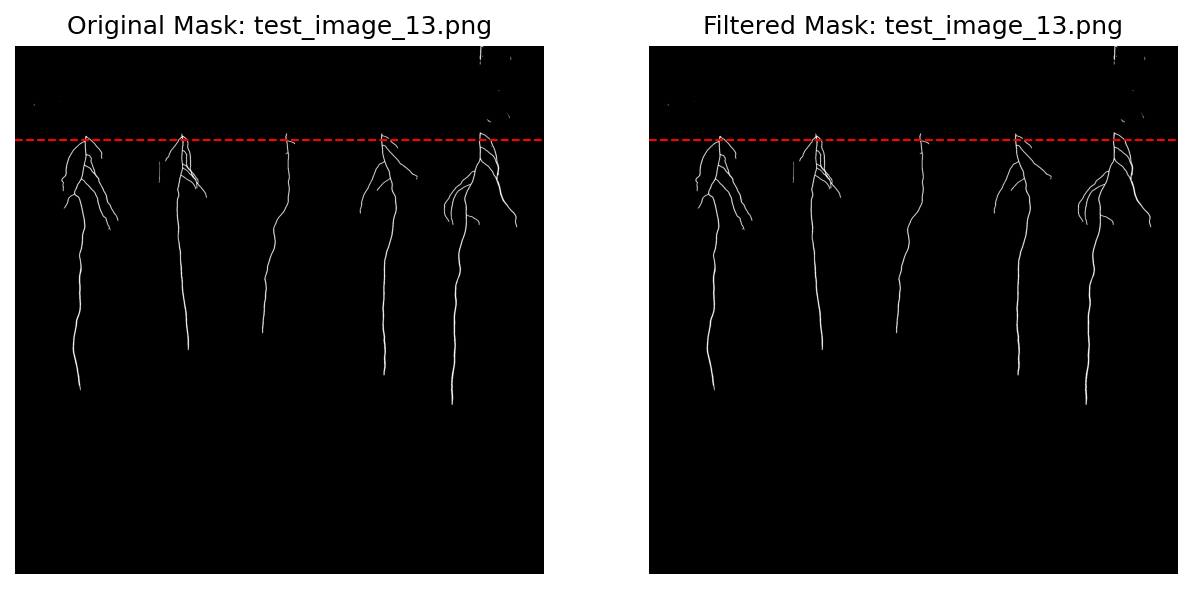

Processing mask for test_image_14.png...
Visualizing mask filtering for test_image_14.png


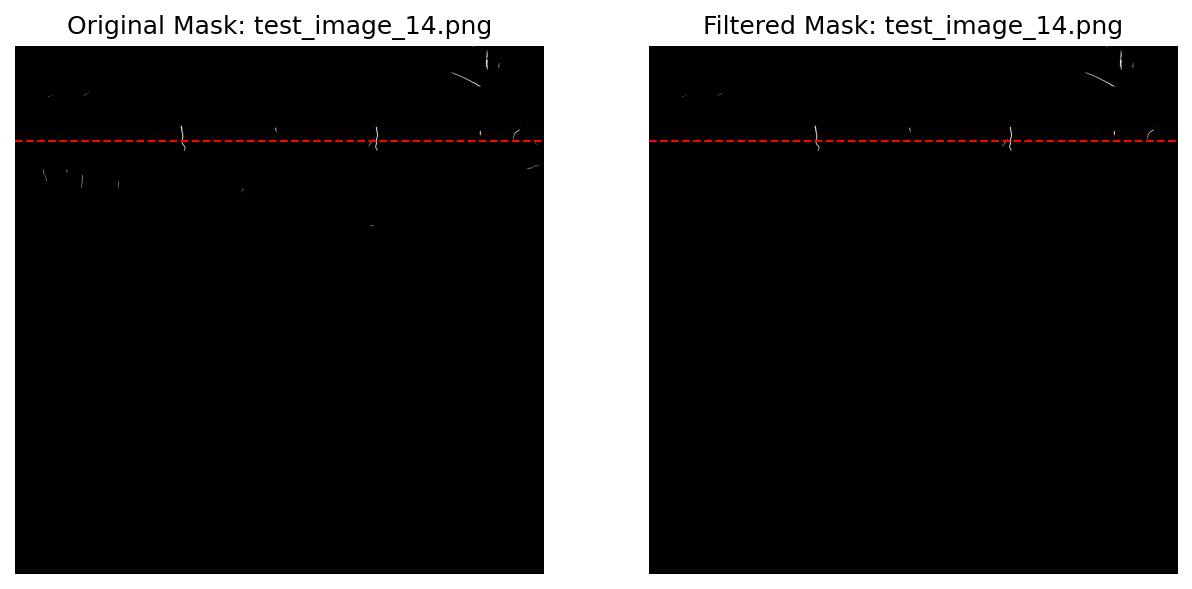

Processing mask for test_image_15.png...
Visualizing mask filtering for test_image_15.png


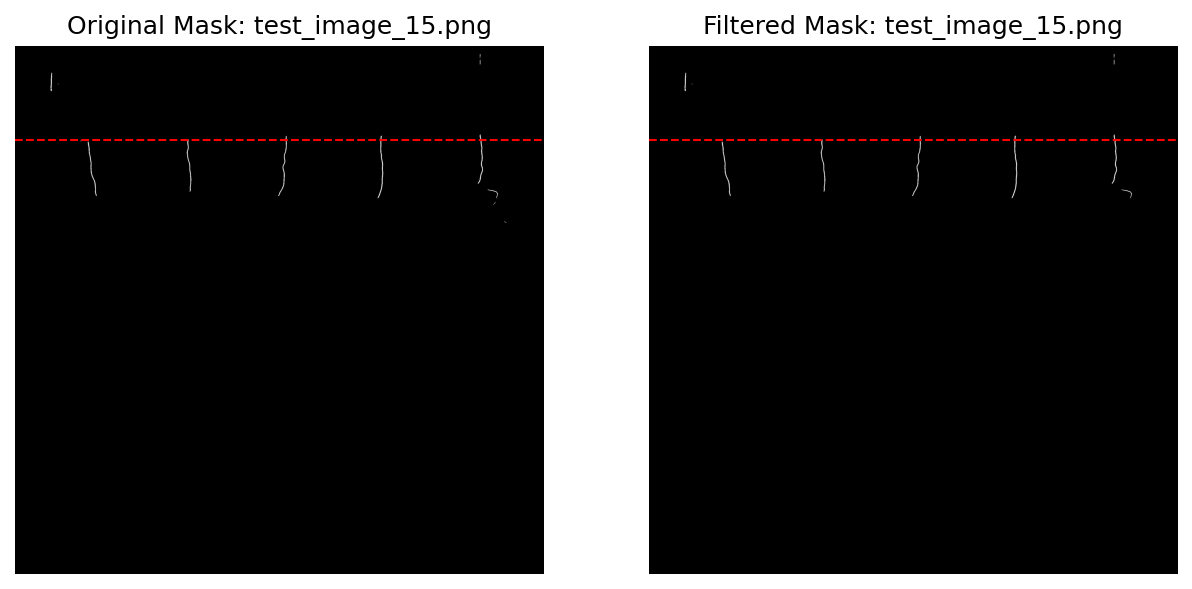

Processing mask for test_image_16.png...
Visualizing mask filtering for test_image_16.png


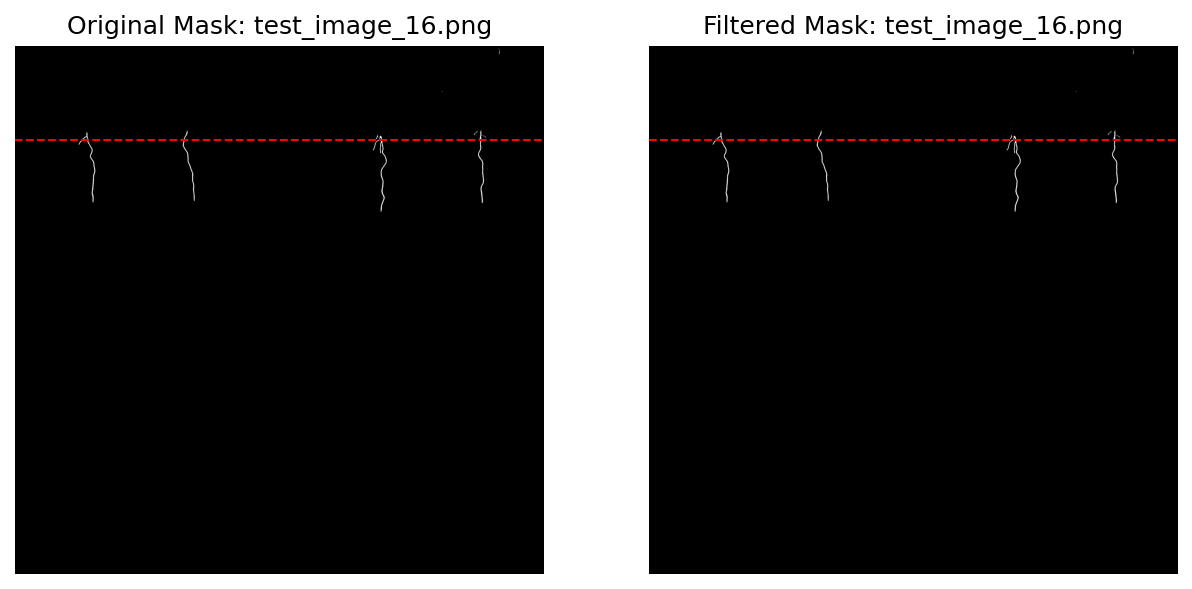

Processing mask for test_image_17.png...
Visualizing mask filtering for test_image_17.png


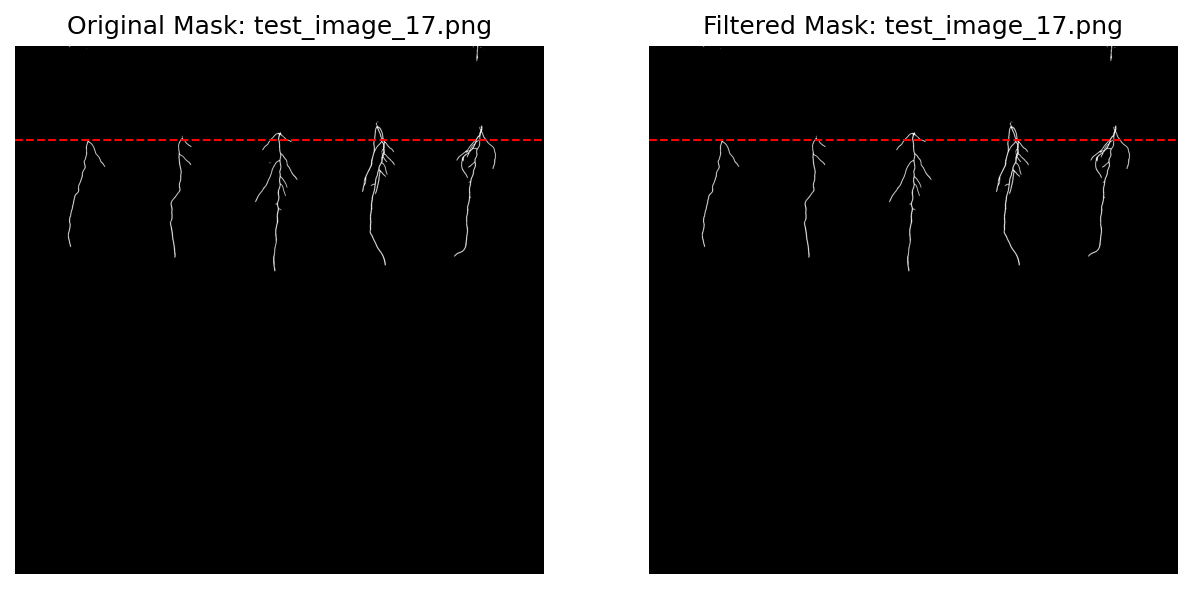

Processing mask for test_image_18.png...
Visualizing mask filtering for test_image_18.png


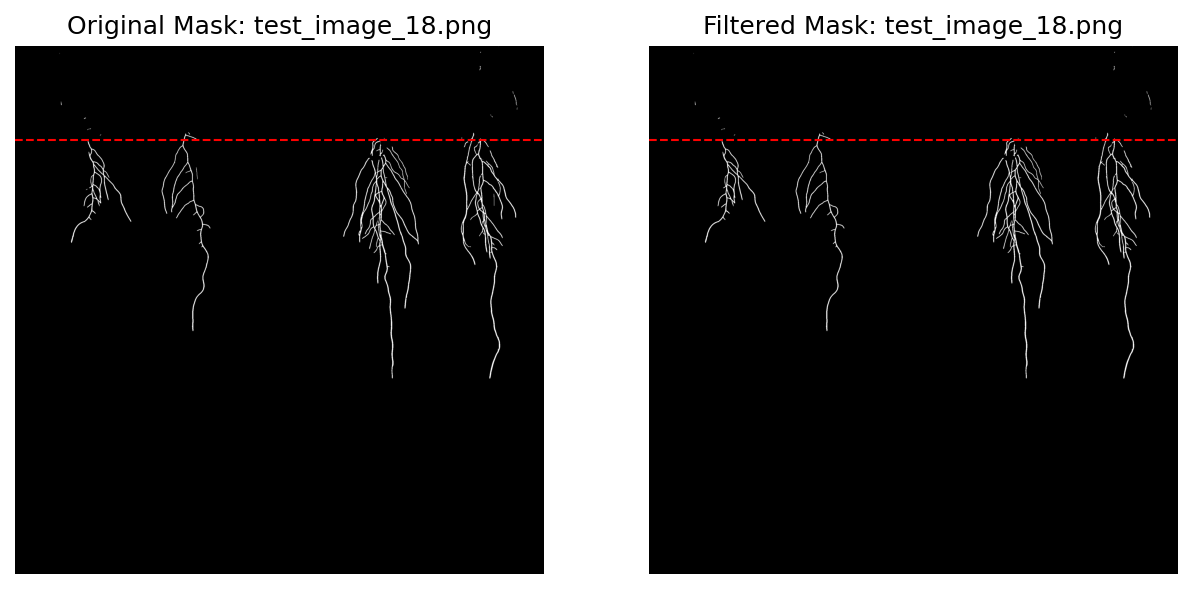

Processing mask for test_image_2.png...
Visualizing mask filtering for test_image_2.png


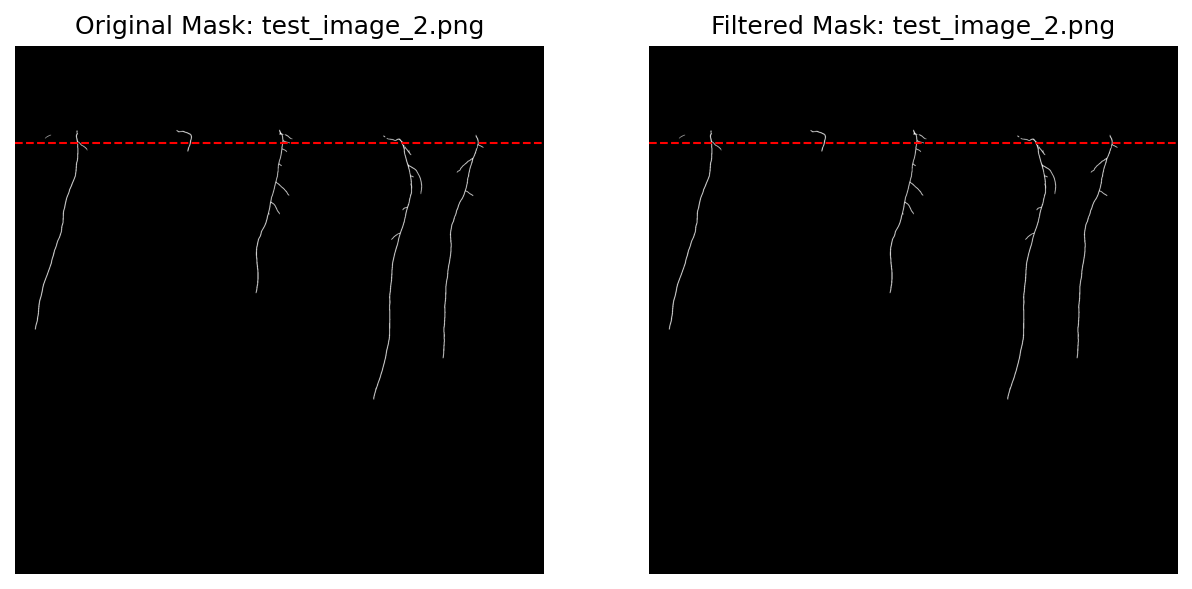

Processing mask for test_image_3.png...
Visualizing mask filtering for test_image_3.png


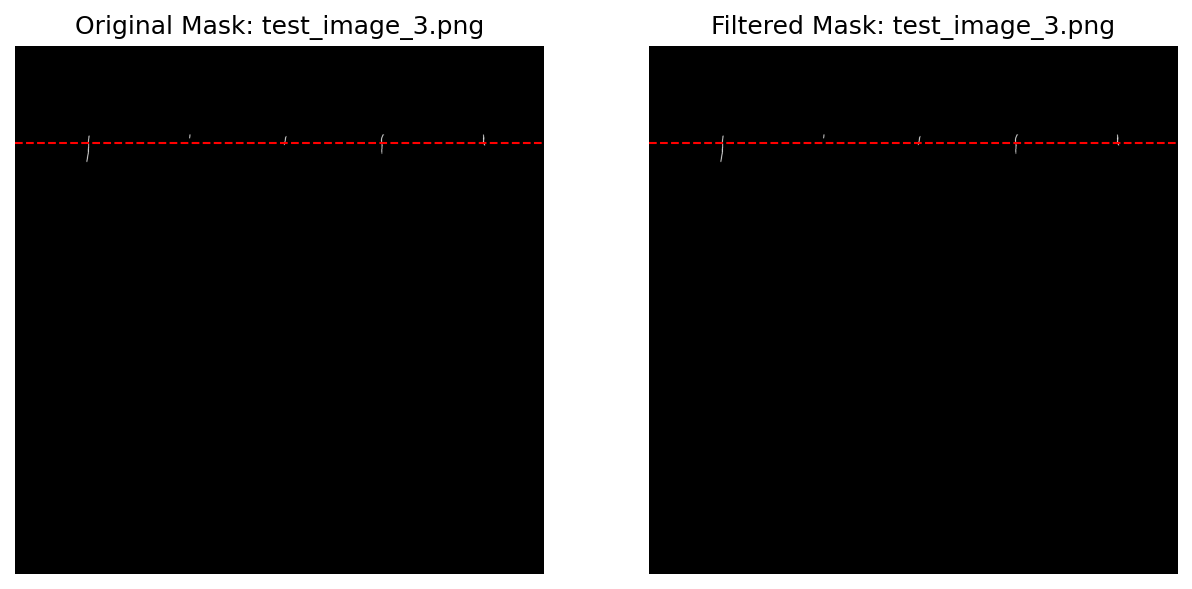

Processing mask for test_image_4.png...
Visualizing mask filtering for test_image_4.png


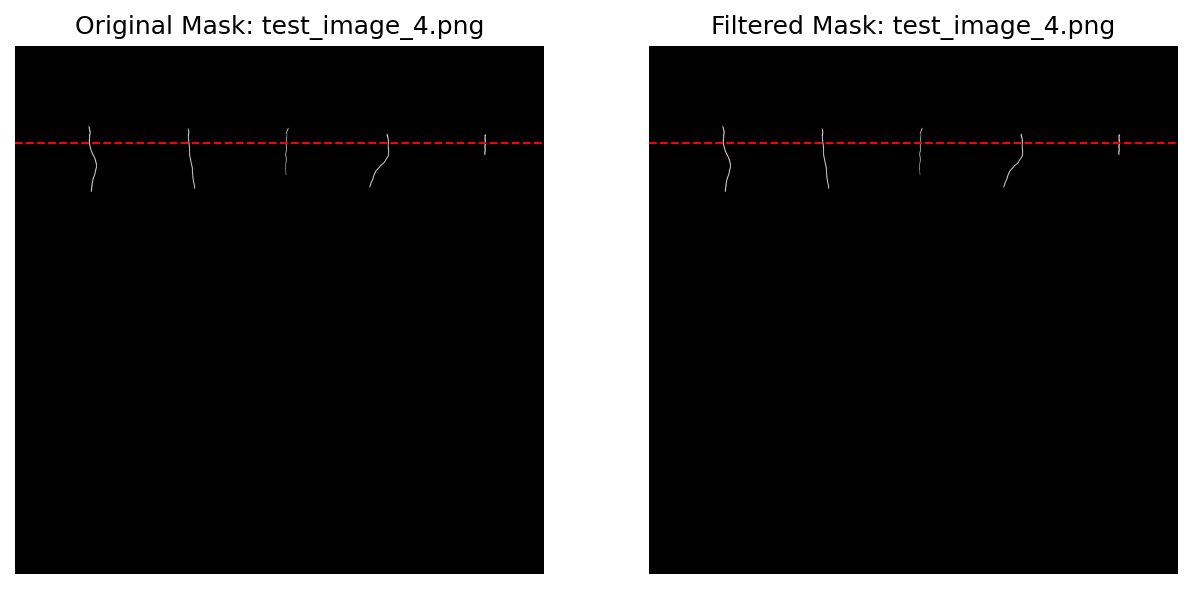

Processing mask for test_image_5.png...
Visualizing mask filtering for test_image_5.png


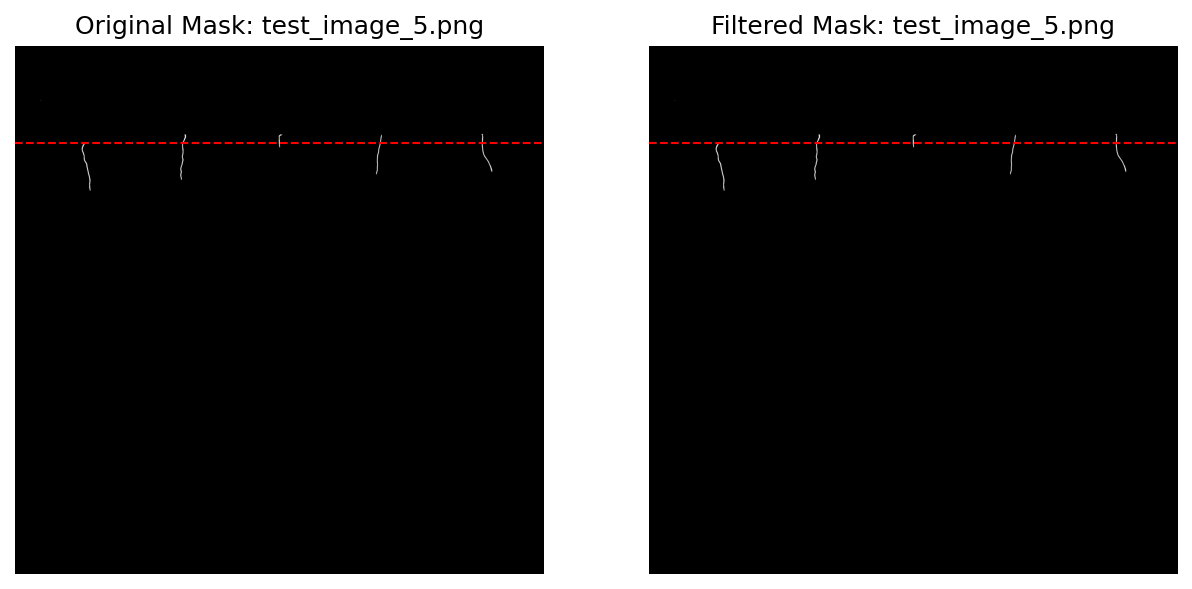

Processing mask for test_image_6.png...
Visualizing mask filtering for test_image_6.png


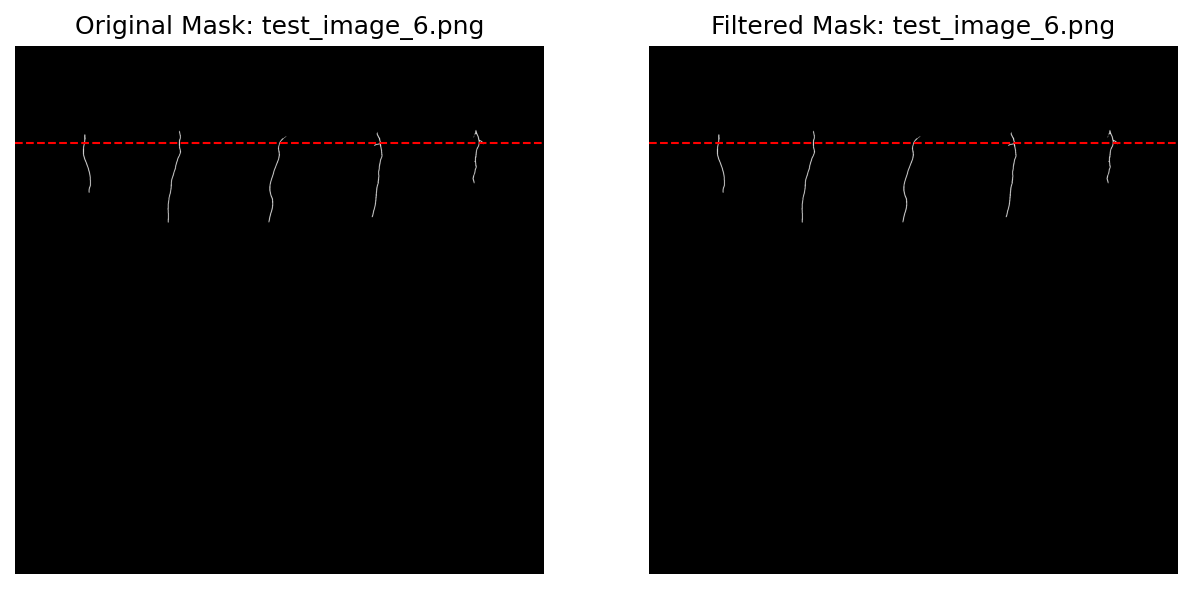

Processing mask for test_image_7.png...
Visualizing mask filtering for test_image_7.png


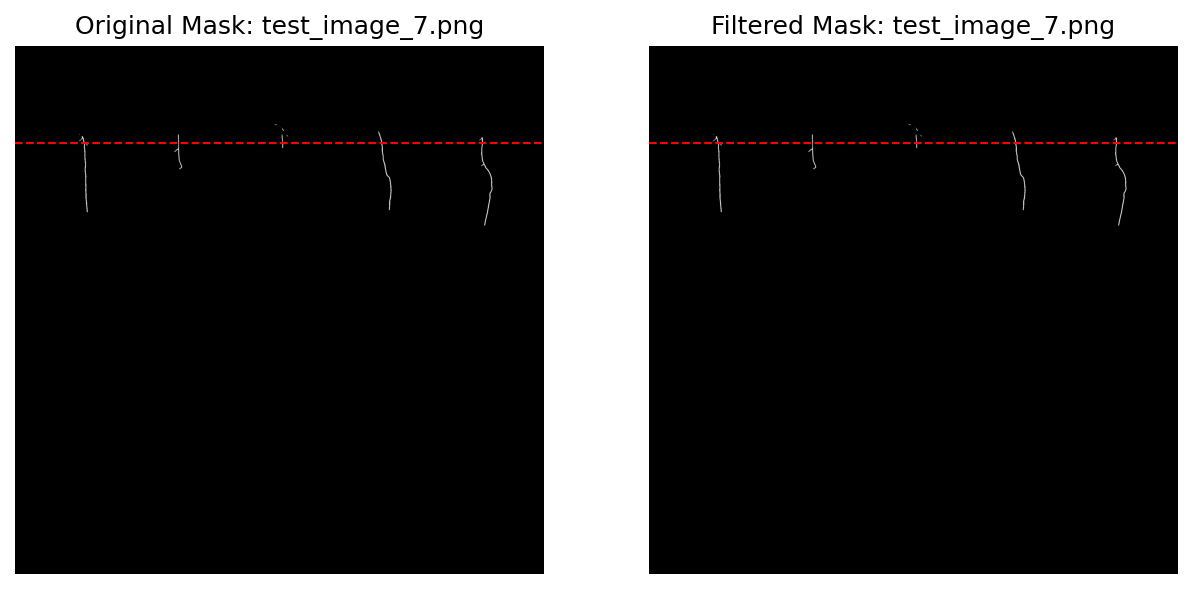

Processing mask for test_image_8.png...
Visualizing mask filtering for test_image_8.png


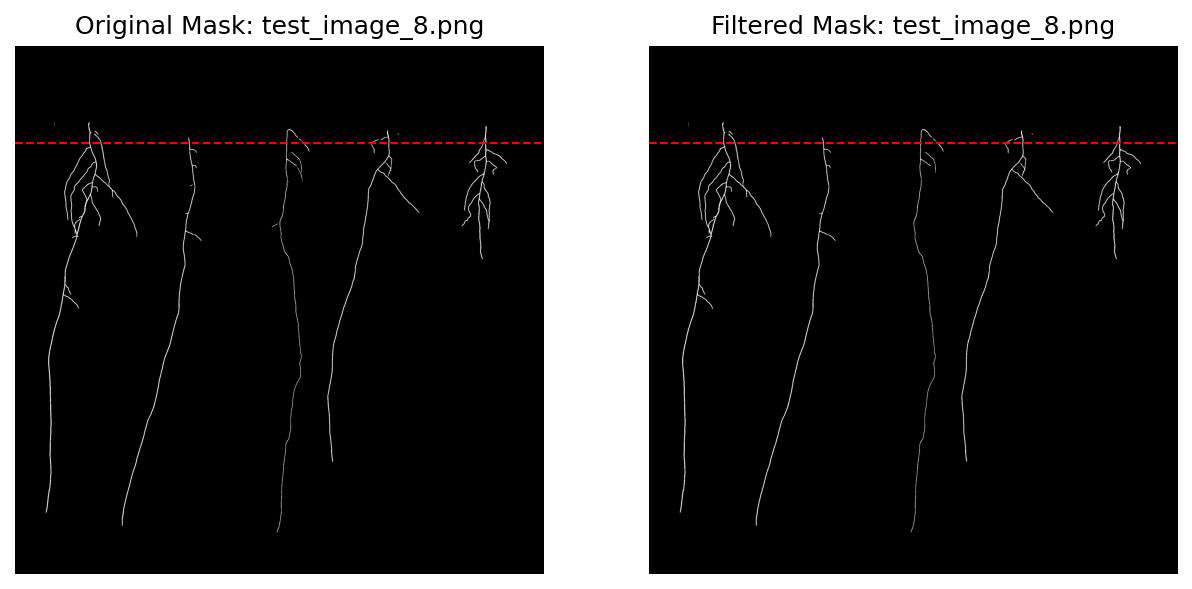

Processing mask for test_image_9.png...
Visualizing mask filtering for test_image_9.png


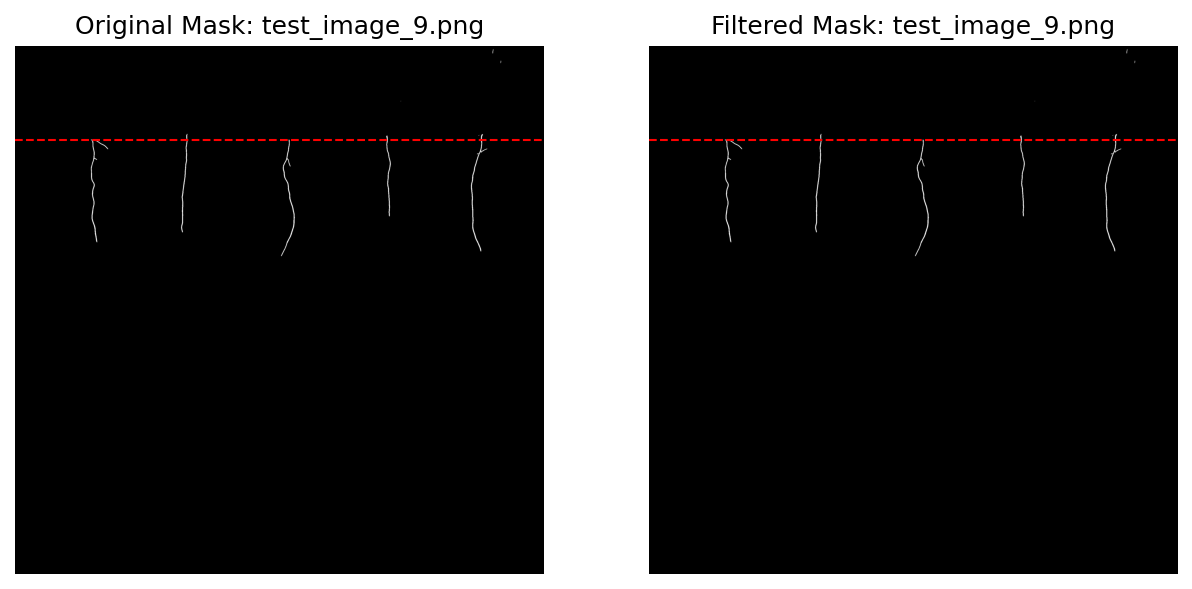

In [20]:
from skimage import morphology
import matplotlib.pyplot as plt
import numpy as np

def remove_small_and_low_objects(processed_masks, size_threshold=20, y_threshold=500):
    """
    Remove elements that are below a specified y-threshold and smaller than a size threshold.
    Visualizes the original and filtered masks with the y-threshold line.

    Parameters:
        processed_masks (dict): Dictionary of processed masks with IDs as keys.
        size_threshold (int): Minimum size of components to keep.
        y_threshold (int): Maximum y-coordinate for the top of a component to be kept.

    Returns:
        dict: Dictionary with IDs as keys and filtered masks as values.
    """
    filtered_masks = {}

    for file_name, mask in processed_masks.items():
        print(f"Processing mask for {file_name}...")

        # Initialize a blank mask to store results
        h, w = mask.shape
        filtered_mask = np.zeros_like(mask, dtype=np.uint8)

        # Label connected components in the mask
        labeled_mask, num_labels = morphology.label(mask > 0, connectivity=2, return_num=True)

        # Process each labeled component
        for label in range(1, num_labels + 1):
            component = (labeled_mask == label)
            size = component.sum()
            top_y = np.min(np.where(component)[0]) if size > 0 else None

            # Retain components that either:
            # - Have size >= size_threshold
            # - Have top_y < y_threshold
            if size >= size_threshold or (top_y is not None and top_y < y_threshold):
                filtered_mask[component] = 255

        filtered_masks[file_name] = filtered_mask

        # Visualize the original and filtered masks with y-threshold line
        print(f"Visualizing mask filtering for {file_name}")
        f, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
        ax[0].imshow(mask, cmap='gray')
        ax[0].axhline(y=y_threshold, color='red', linestyle='--', linewidth=1)  # Plot y-threshold
        ax[0].axis('off')
        ax[0].set_title(f'Original Mask: {file_name}')
        ax[1].imshow(filtered_mask, cmap='gray')
        ax[1].axhline(y=y_threshold, color='red', linestyle='--', linewidth=1)  # Plot y-threshold
        ax[1].axis('off')
        ax[1].set_title(f'Filtered Mask: {file_name}')
        plt.show()

    return filtered_masks


# Define thresholds
size_threshold = 200
y_threshold = 500

# Apply the function
filtered_masks = remove_small_and_low_objects(processed_masks, size_threshold, y_threshold)


### Creating bounding boxes:

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def extract_bounding_boxes_from_mask(mask, min_area=200):
    """
    Extract bounding boxes from a binary mask.

    Parameters:
        mask (np.ndarray): Binary mask with connected components.
        min_area (int): Minimum area threshold for valid bounding boxes.

    Returns:
        list: List of bounding boxes [(x_min, y_min, x_max, y_max), ...].
    """
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # Extract bounding boxes from stats
    bounding_boxes = []
    for stat in stats[1:]:  # Skip the background (index 0)
        x, y, w, h, area = stat
        if area >= min_area:
            bounding_boxes.append((x, y, x + w, y + h))
    return bounding_boxes

def filter_bounding_boxes(bboxes, iou_threshold=0.00001, min_y_threshold=1000, exclude_top_y=150):
    """
    Filter bounding boxes using Non-Maximum Suppression (NMS) and vertical thresholds.

    Parameters:
        bboxes (list): List of bounding boxes [(x_min, y_min, x_max, y_max)].
        iou_threshold (float): Threshold for IoU to consider boxes as overlapping.
        min_y_threshold (int): Maximum y_min value for a bounding box to be kept.
        exclude_top_y (int): Minimum y_min value for a bounding box to be kept.

    Returns:
        list: Filtered list of bounding boxes after applying the thresholds and NMS.
    """
    if len(bboxes) == 0:
        return []

    # Strictly filter out boxes based on vertical thresholds
    bboxes = [box for box in bboxes if exclude_top_y < box[1] < min_y_threshold]

    # Sort by area (descending order)
    bboxes = sorted(bboxes, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]), reverse=True)

    # Perform Non-Maximum Suppression (NMS)
    filtered_bboxes = []
    while bboxes:
        largest_box = bboxes.pop(0)
        filtered_bboxes.append(largest_box)
        bboxes = [
            box for box in bboxes
            if calculate_iou(largest_box, box) < iou_threshold
        ]
    return filtered_bboxes


In [12]:
def process_masks_and_extract_bboxes_vertical(filtered_masks, num_sections=5, min_area=10, exclude_below_y=1000, exclude_top_y=150):
    """
    Process masks to extract and retain only the largest bounding box per section, keeping only those in the top range.

    Parameters:
        filtered_masks (dict): Dictionary of filtered masks.
        num_sections (int): Number of vertical sections to divide the mask into.
        min_area (int): Minimum area for bounding boxes.
        exclude_below_y (int): Exclude bounding boxes with y_min > this threshold.
        exclude_top_y (int): Exclude bounding boxes with y_min <= this threshold.

    Returns:
        dict: Dictionary with the largest top bounding box for each section of each mask.
    """
    sectioned_bboxes = {}

    for file_name, mask in filtered_masks.items():
        print(f"Processing mask for {file_name}...")

        # Get mask dimensions and calculate section width
        h, w = mask.shape
        section_width = w // num_sections

        # Divide mask into vertical sections (columns) and process each section
        mask_bboxes = []
        for i in range(num_sections):
            # Define the column slice for the current section
            section_mask = mask[:, i * section_width:(i + 1) * section_width]

            # Extract bounding boxes for this section
            bboxes = extract_bounding_boxes_from_mask(section_mask, min_area)

            # Adjust bounding boxes to their original coordinates within the full mask
            adjusted_bboxes = [
                (x + i * section_width, y, x_max + i * section_width, y_max)
                for (x, y, x_max, y_max) in bboxes
            ]

            # Filter bounding boxes based on vertical thresholds
            filtered_bboxes = filter_bounding_boxes(adjusted_bboxes, min_y_threshold=exclude_below_y, exclude_top_y=exclude_top_y)

            # Retain only the largest bounding box
            if filtered_bboxes:
                largest_bbox = max(filtered_bboxes, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]))
                mask_bboxes.append([largest_bbox])  # Wrap in a list for consistency
            else:
                mask_bboxes.append([])  # No bounding box for this section

        sectioned_bboxes[file_name] = mask_bboxes

    return sectioned_bboxes


In [13]:
def visualize_masks_and_bboxes_vertical(filtered_masks, sectioned_bboxes, num_sections=5):
    """
    Visualize masks with bounding boxes overlaid for vertical sections (columns) for all images.

    Parameters:
        filtered_masks (dict): Dictionary of filtered masks.
        sectioned_bboxes (dict): Dictionary of bounding boxes for each mask.
        num_sections (int): Number of vertical sections in the mask.
    """
    for file_name, mask in filtered_masks.items():
        h, w = mask.shape
        section_width = w // num_sections

        # Plot mask with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask with Bounding Boxes: {file_name}")
        plt.axis("off")

        # Overlay bounding boxes for each vertical section
        for i, bboxes in enumerate(sectioned_bboxes[file_name]):
            for bbox in bboxes:
                x_min, y_min, x_max, y_max = bbox
                plt.gca().add_patch(plt.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    edgecolor="red", fill=False, linewidth=1
                ))

            # Draw vertical section boundary lines
            plt.axvline(x=i * section_width, color="blue", linestyle="--", linewidth=1)

        plt.show()


Processing mask for test_image_1.png...
Processing mask for test_image_10.png...
Processing mask for test_image_11.png...
Processing mask for test_image_12.png...
Processing mask for test_image_13.png...
Processing mask for test_image_14.png...
Processing mask for test_image_15.png...
Processing mask for test_image_16.png...
Processing mask for test_image_17.png...
Processing mask for test_image_18.png...
Processing mask for test_image_2.png...
Processing mask for test_image_3.png...
Processing mask for test_image_4.png...
Processing mask for test_image_5.png...
Processing mask for test_image_6.png...
Processing mask for test_image_7.png...
Processing mask for test_image_8.png...
Processing mask for test_image_9.png...


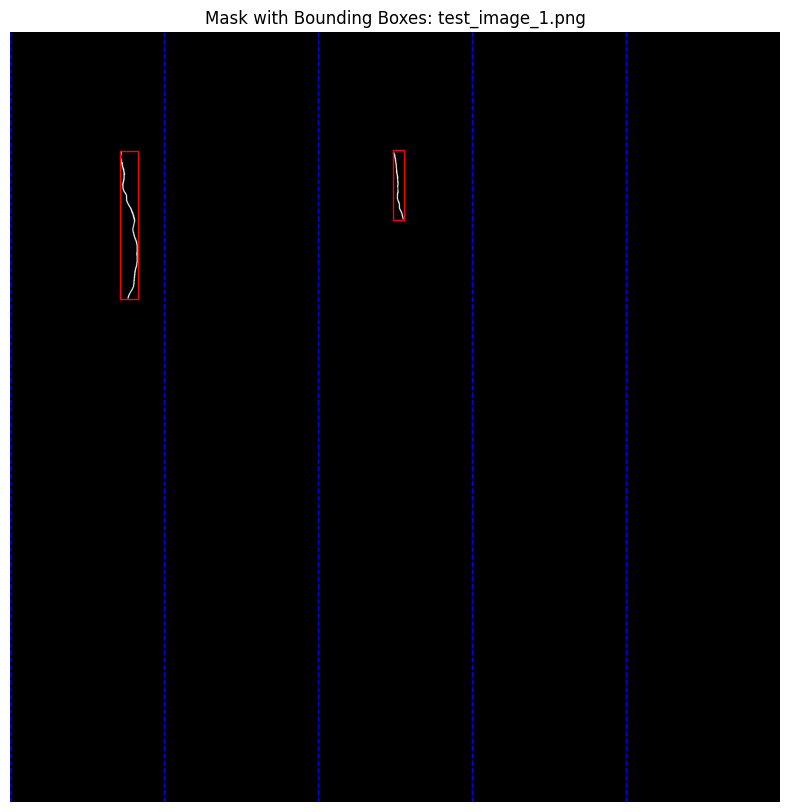

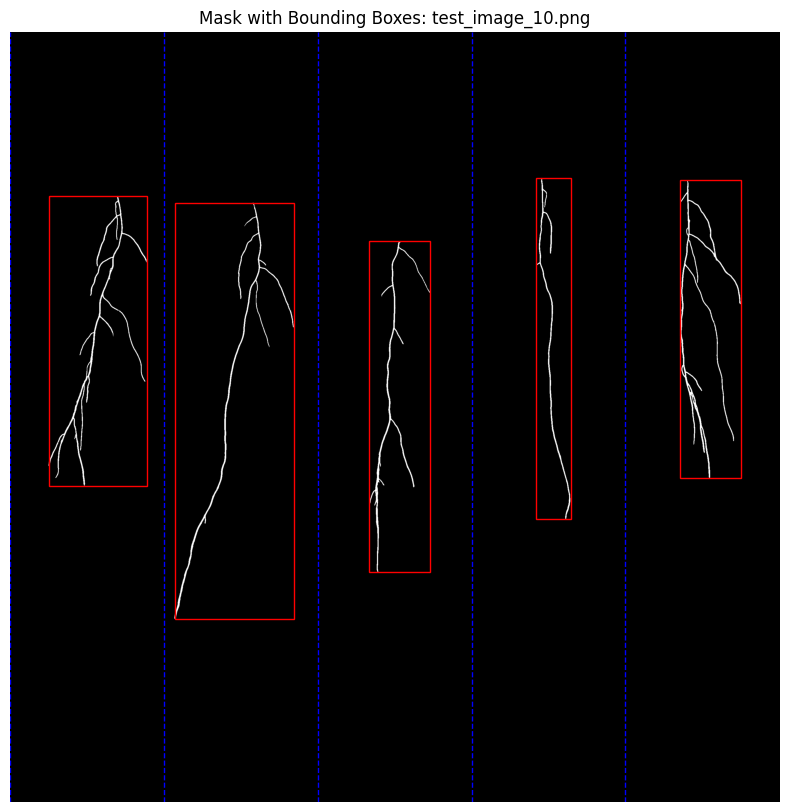

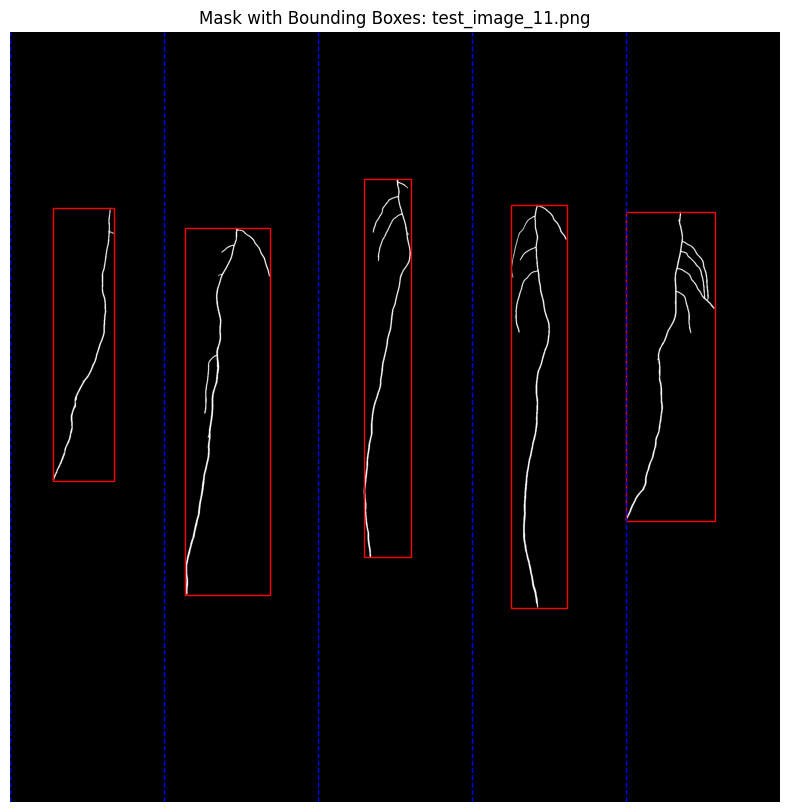

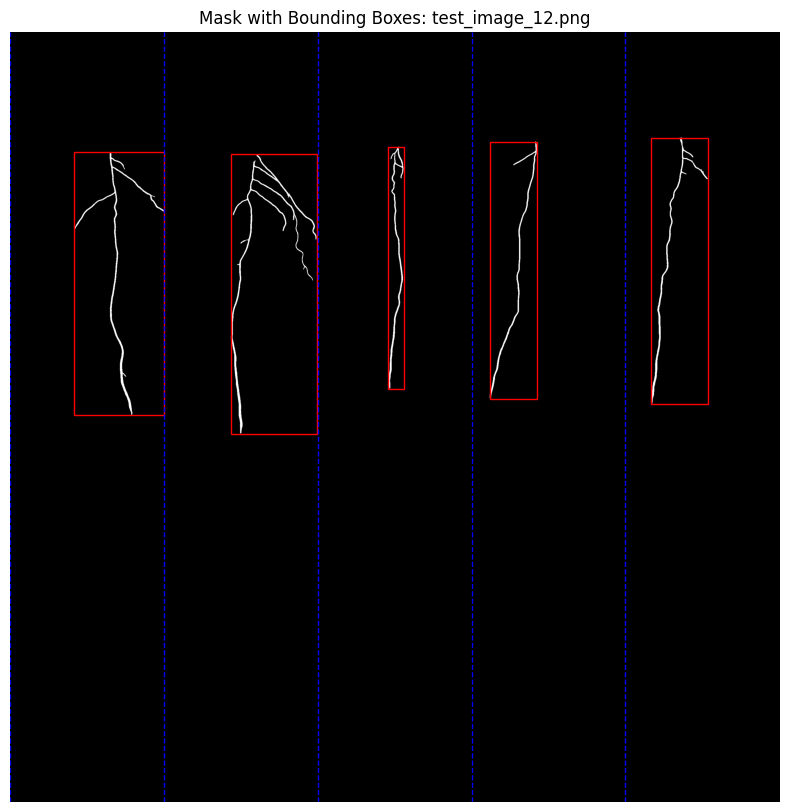

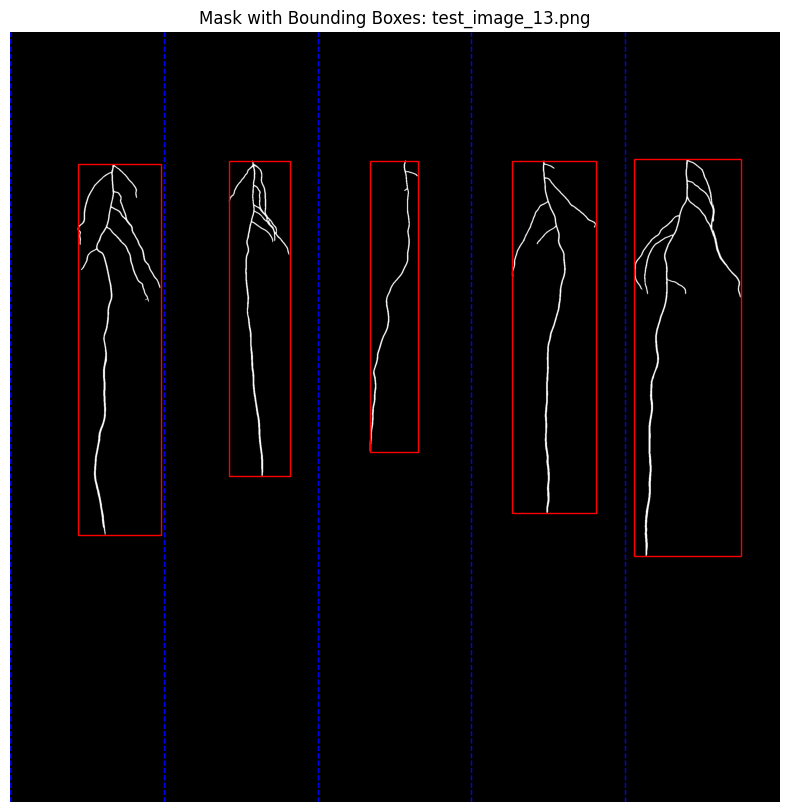

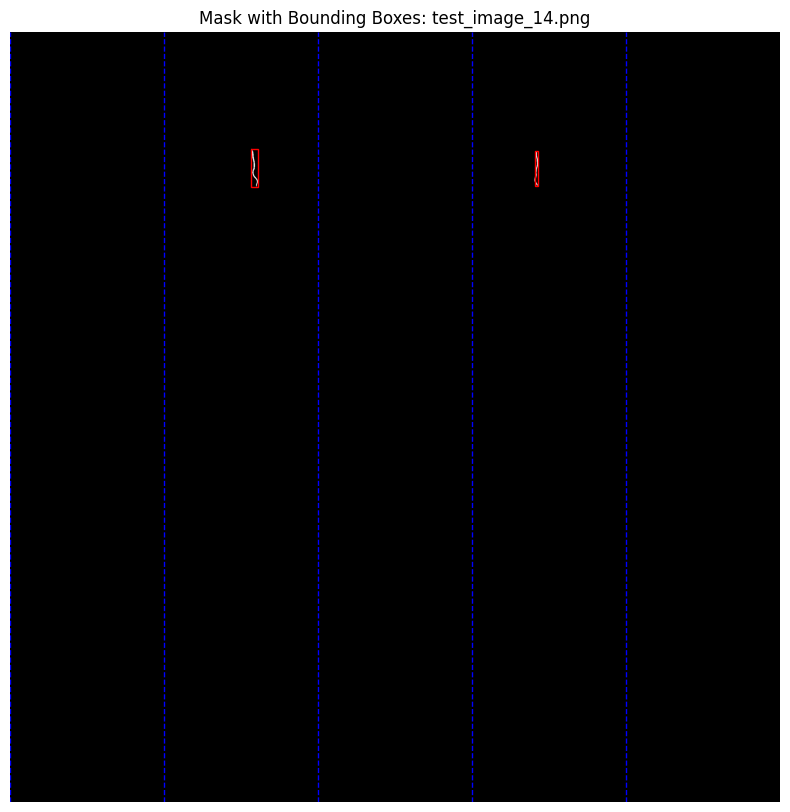

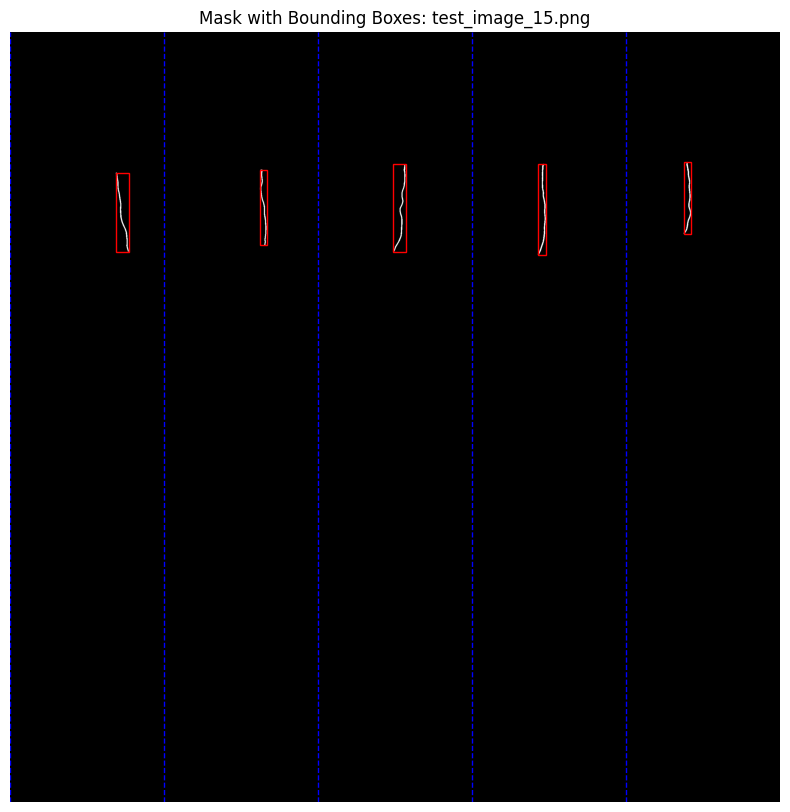

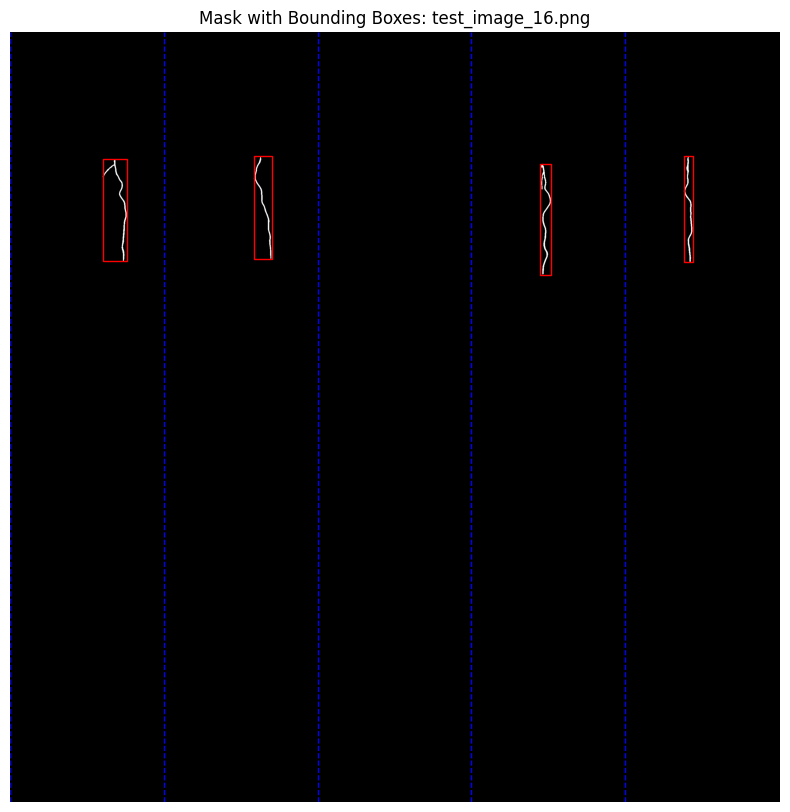

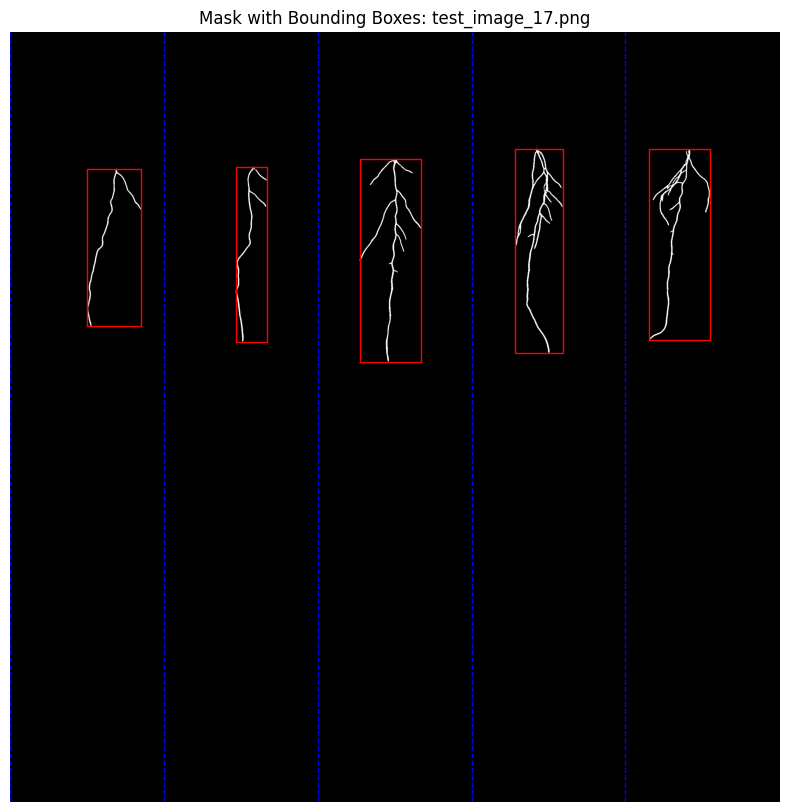

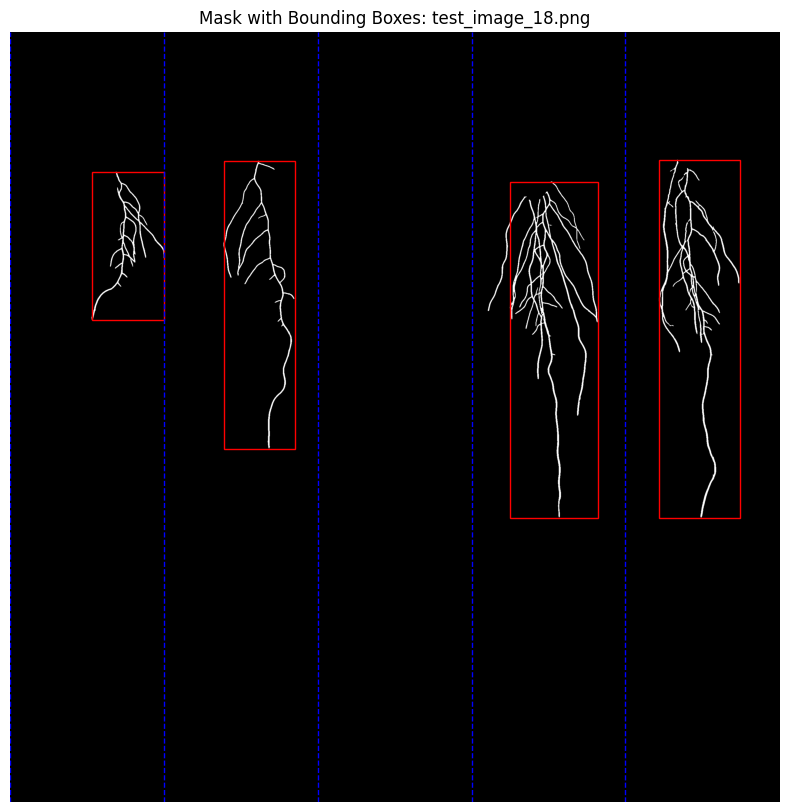

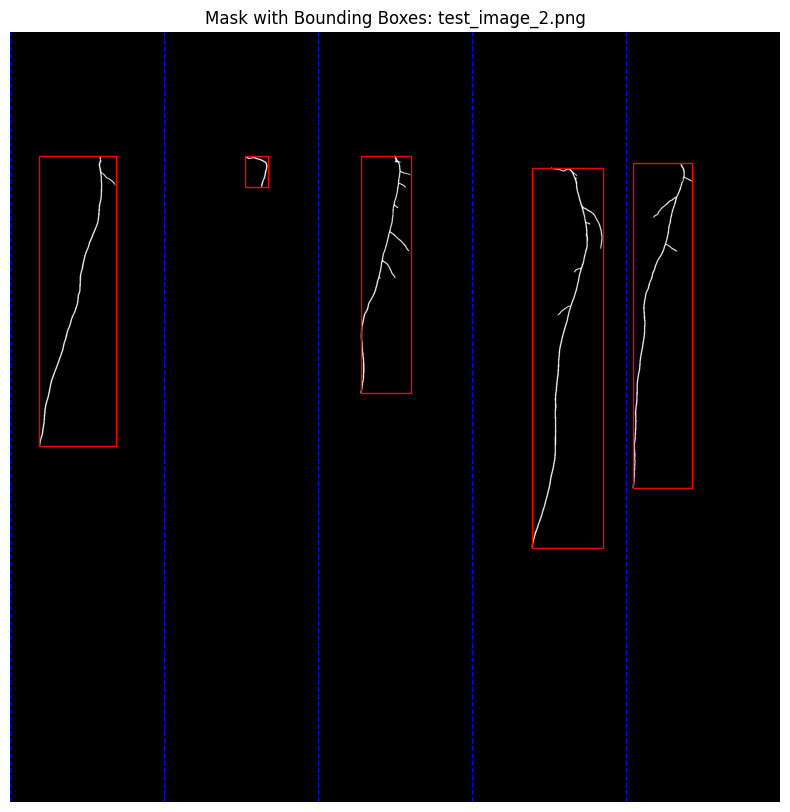

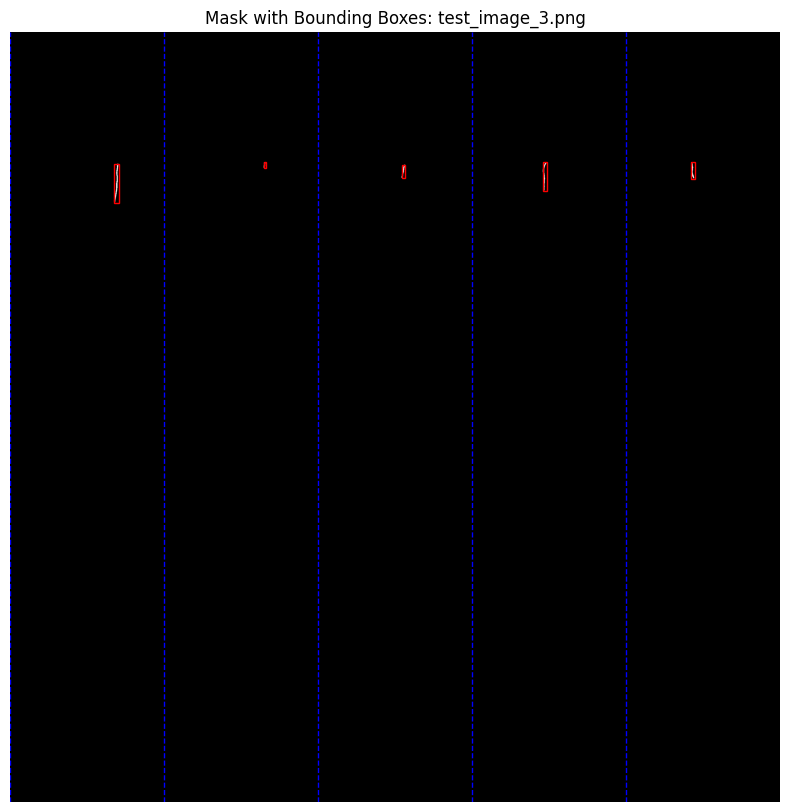

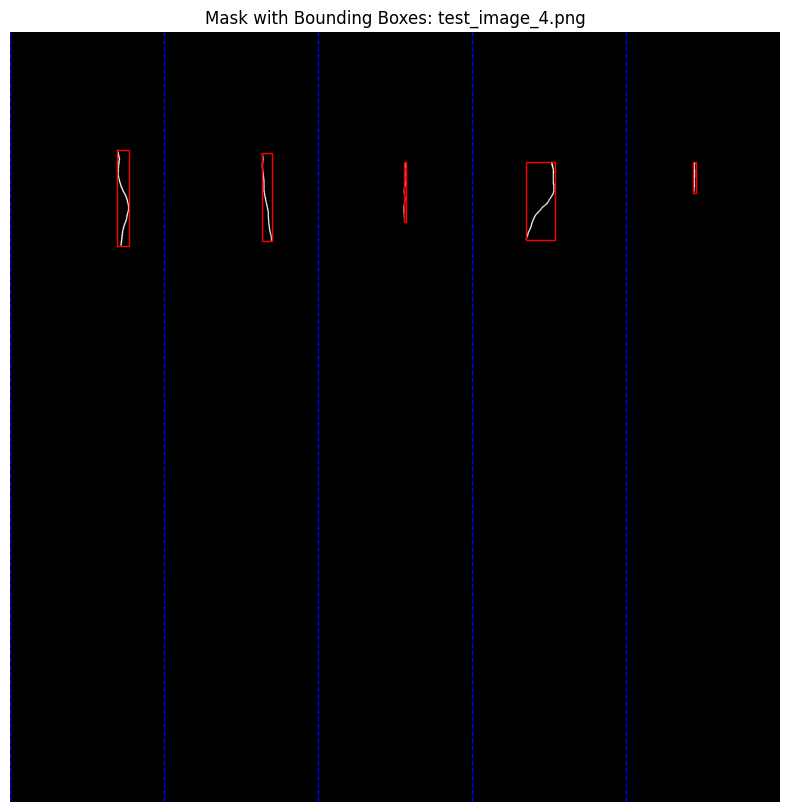

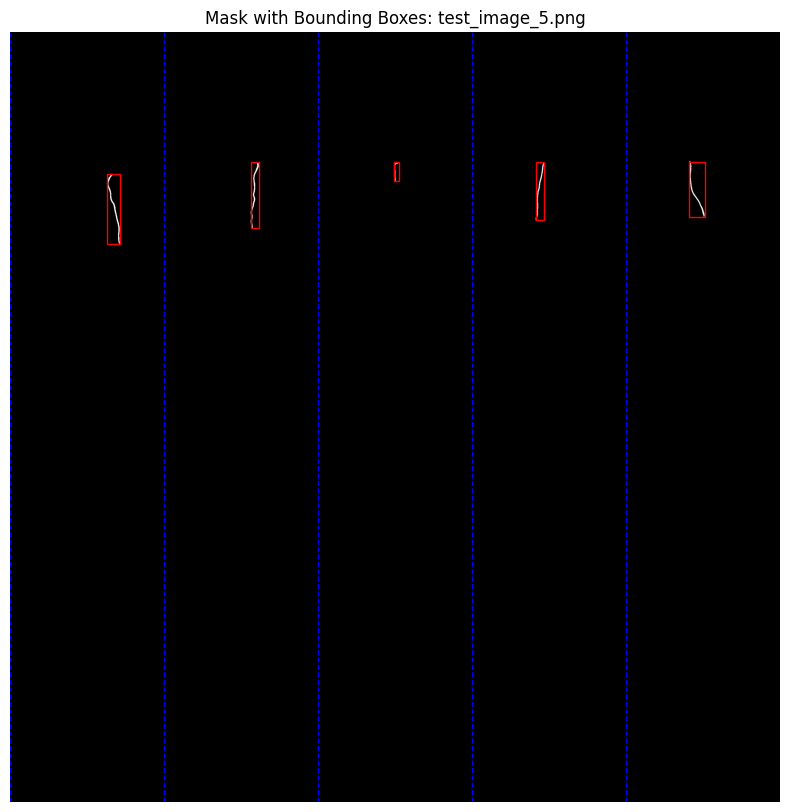

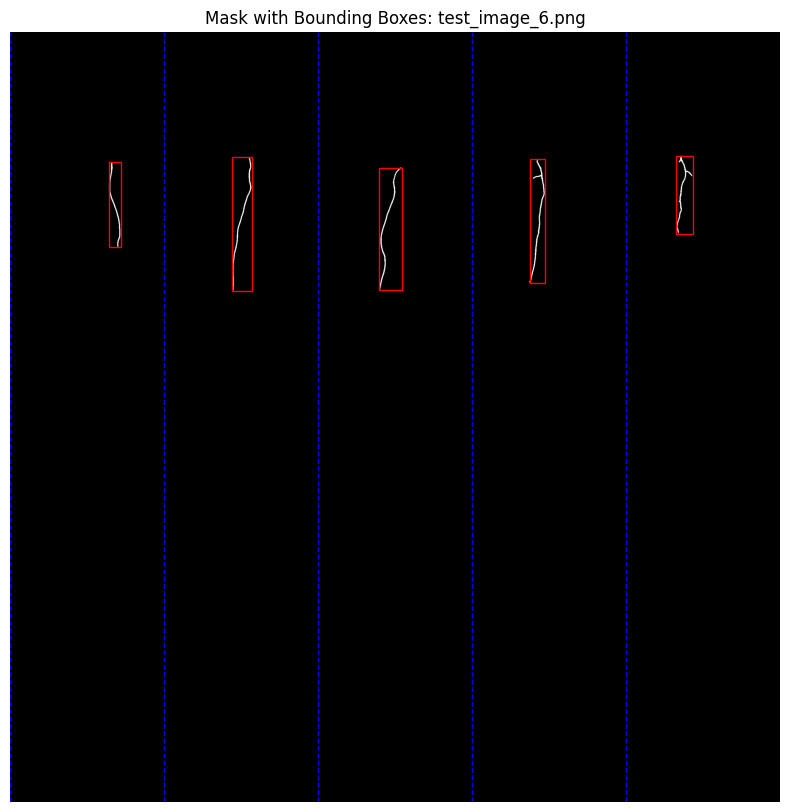

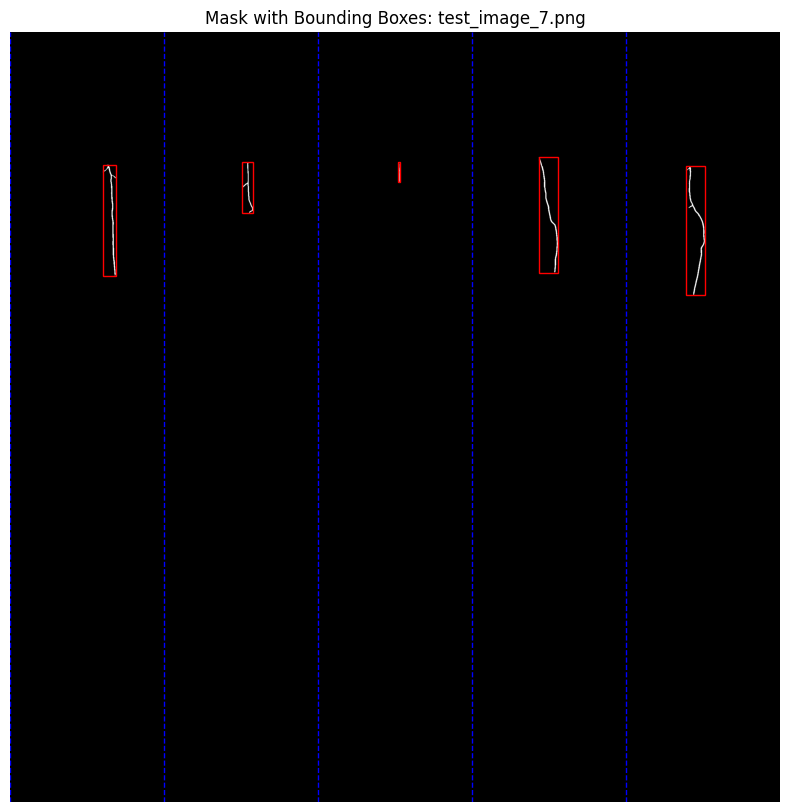

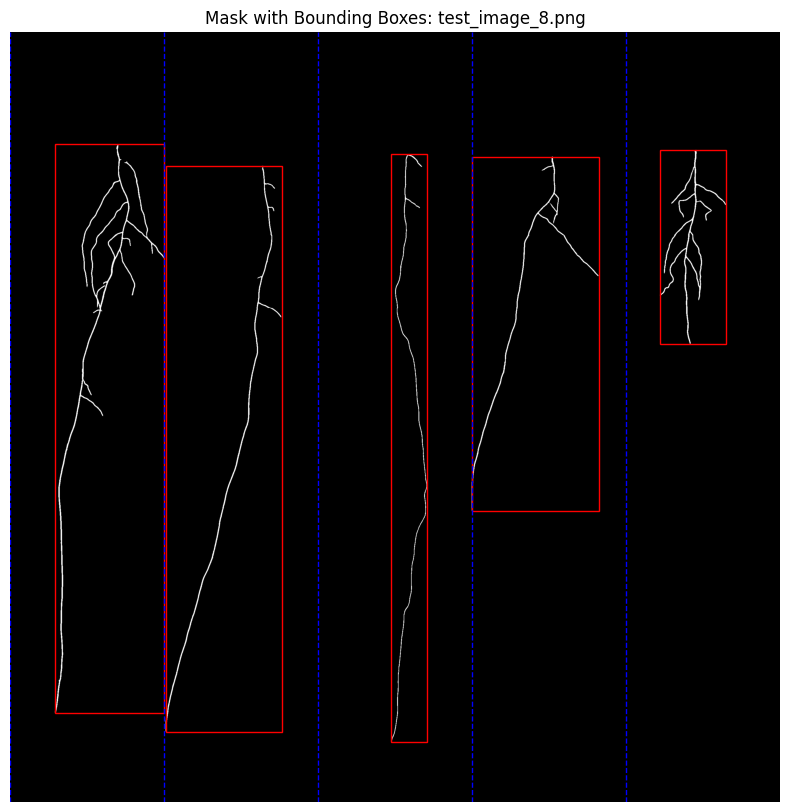

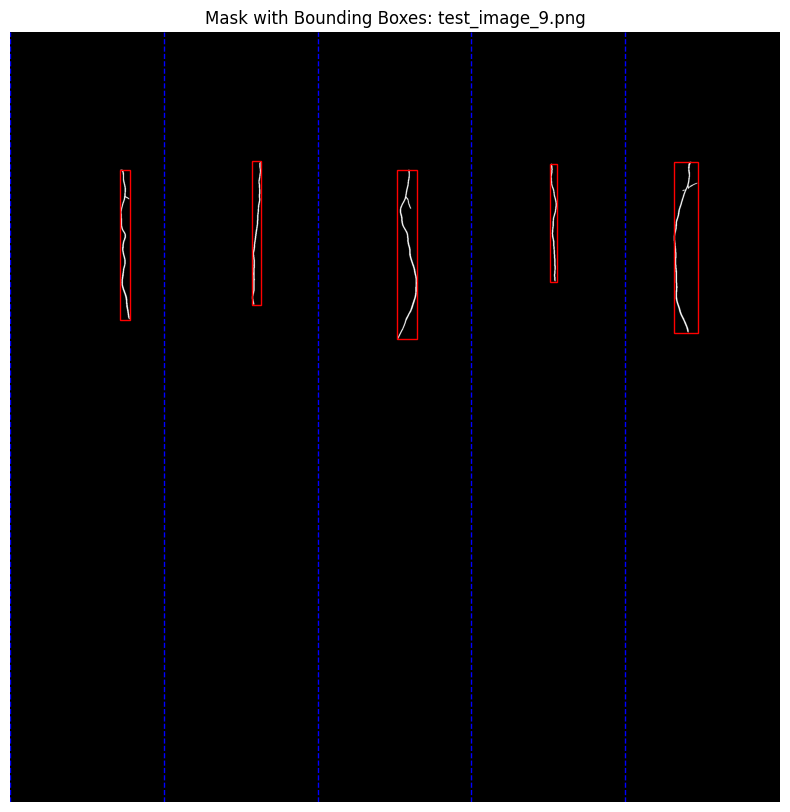

In [14]:

# Process masks and extract bounding boxes for vertical sections
sectioned_bboxes_vertical = process_masks_and_extract_bboxes_vertical(filtered_masks, num_sections=5)

# Visualize masks and bounding boxes for vertical sections
visualize_masks_and_bboxes_vertical(filtered_masks, sectioned_bboxes_vertical, num_sections=5)



## Calculating root length:

In [15]:
import pandas as pd
from skimage.morphology import skeletonize
from skan.csr import skeleton_to_csgraph
import networkx as nx
import os

def calculate_root_lengths(labeled_mask, original_mask):
    """
    Calculate root lengths for each labeled root in the mask.

    Parameters:
        labeled_mask (np.ndarray): Labeled mask with unique IDs for each root.
        original_mask (np.ndarray): Original binary mask of the roots.

    Returns:
        dict: Dictionary of root IDs and their calculated lengths.
    """
    skeleton = skeletonize(labeled_mask > 0)
    root_lengths = {}

    for root_id in np.unique(labeled_mask):
        if root_id == 0:  # Skip background
            continue

        root_skeleton = (labeled_mask == root_id) & skeleton
        graph, coordinates = skeleton_to_csgraph(root_skeleton)

        G = nx.Graph()
        for i, j in zip(*graph.nonzero()):
            G.add_edge(i, j, weight=graph[i, j])

        try:
            # Find topmost and bottommost nodes
            topmost_node = min(G.nodes, key=lambda n: coordinates[0][n])
            bottommost_node = max(G.nodes, key=lambda n: coordinates[0][n])

            # Calculate root length
            dist = nx.dijkstra_path_length(G, source=topmost_node, target=bottommost_node, weight='weight')
            root_lengths[root_id] = dist
        except Exception:
            root_lengths[root_id] = 0  # Handle roots with no valid path

    return root_lengths


def create_single_component_labeled_mask_vertical(sectioned_bboxes, filtered_masks):
    """
    Create labeled masks for each vertical section with the largest bounding box.

    Parameters:
        sectioned_bboxes (dict): Sectioned bounding boxes for each mask.
        filtered_masks (dict): Original filtered masks.

    Returns:
        dict: Labeled masks for each image.
    """
    labeled_masks = {}

    for file_name, bboxes_per_section in sectioned_bboxes.items():
        print(f"Creating labeled mask for {file_name}...")

        # Get the original mask
        original_mask = filtered_masks[file_name]

        # Initialize a blank labeled mask
        labeled_mask = np.zeros_like(original_mask, dtype=np.uint16)

        for section_idx, bboxes in enumerate(bboxes_per_section):
            if not bboxes:  # No bounding boxes in this section
                continue

            # Use the largest bounding box
            x_min, y_min, x_max, y_max = bboxes[0]

            # Extract the region of the mask and label connected components
            region = original_mask[y_min:y_max, x_min:x_max]
            labeled_components, num_components = label(region > 0)

            if num_components > 0:
                # Find the largest component
                component_sizes = [(labeled_components == i).sum() for i in range(1, num_components + 1)]
                largest_component_idx = component_sizes.index(max(component_sizes)) + 1  # 1-based index

                # Assign the label to the largest component
                largest_component = (labeled_components == largest_component_idx)
                labeled_mask[y_min:y_max, x_min:x_max][largest_component] = section_idx + 1

        labeled_masks[file_name] = labeled_mask
        print(f"Labeled mask created for {file_name}.")

    return labeled_masks


def calculate_and_save_root_lengths_vertical(labeled_masks, filtered_masks, output_csv_path):
    """
    Calculate root lengths for each section and save results to a CSV.

    Parameters:
        labeled_masks (dict): Labeled masks with one component per section.
        filtered_masks (dict): Original masks for reference.
        output_csv_path (str): Path to save the output CSV file.

    Returns:
        None
    """
    results = []

    for file_name, labeled_mask in labeled_masks.items():
        print(f"Calculating root lengths for {file_name}...")
        original_mask = filtered_masks[file_name]

        # Remove the file extension from the file name
        base_name = os.path.splitext(file_name)[0]

        # Calculate root lengths
        root_lengths = calculate_root_lengths(labeled_mask, original_mask)

        # Ensure there are exactly 5 sections (plants)
        for section_idx in range(1, 6):  # 1-based index for 5 plants
            plant_id = f"{base_name}_plant_{section_idx}"
            length = root_lengths.get(section_idx, 0)  # Default to 0 if no root detected
            results.append({"Plant ID": plant_id, "Length (px)": length})

    # Save results to CSV
    df = pd.DataFrame(results, columns=["Plant ID", "Length (px)"])
    df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}.")


### Visualizing the root before saving to a CSV:

In [16]:
def visualize_all_root_lengths(labeled_masks, original_masks):
    """
    Visualize root lengths for each component detected in the labeled masks. 
    Displays skeletons overlaid on the original mask with start and end points marked.

    Parameters:
        labeled_masks (dict): Dictionary of labeled masks with unique IDs for each root.
        original_masks (dict): Dictionary of original binary masks of the roots.

    Returns:
        None
    """
    from skimage.morphology import skeletonize
    from skan.csr import skeleton_to_csgraph
    import networkx as nx
    import matplotlib.pyplot as plt

    for file_name, labeled_mask in labeled_masks.items():
        print(f"Visualizing components for {file_name}...")

        # Skeletonize the entire mask
        original_mask = original_masks[file_name]
        skeleton = skeletonize(labeled_mask > 0)

        # Get root IDs, excluding background
        root_ids = np.unique(labeled_mask)
        root_ids = root_ids[root_ids > 0]

        # Plotting setup
        plt.figure(figsize=(12, 12))
        plt.imshow(original_mask, cmap='gray')
        plt.title(f"Skeleton with Start (Green) and End (Red) Points - {file_name}")

        for idx, root_id in enumerate(root_ids, start=1):
            # Isolate the skeleton for the current root
            root_skeleton = (labeled_mask == root_id) & skeleton

            # Convert skeleton to graph and coordinates
            graph, coordinates = skeleton_to_csgraph(root_skeleton)

            # Convert sparse graph to NetworkX graph
            G = nx.Graph()
            for i, j in zip(*graph.nonzero()):
                G.add_edge(i, j, weight=graph[i, j])

            # Identify topmost and bottommost nodes
            try:
                topmost_node = min(G.nodes, key=lambda n: coordinates[0][n])  # Smallest y (row)
                bottommost_node = max(G.nodes, key=lambda n: coordinates[0][n])  # Largest y (row)

                # Compute the shortest path length using Dijkstra
                dist = nx.dijkstra_path_length(G, source=topmost_node, target=bottommost_node, weight='weight')

                # Get coordinates of start and end points
                start_coords = (coordinates[0][topmost_node], coordinates[1][topmost_node])  # (row, col)
                end_coords = (coordinates[0][bottommost_node], coordinates[1][bottommost_node])  # (row, col)

                # Overlay skeleton points on the visualization
                y_coords, x_coords = np.where(root_skeleton)
                plt.scatter(x_coords, y_coords, c='blue', s=1, alpha=0.5)  # Visualize skeleton points

                # Overlay start and end points
                plt.scatter(start_coords[1], start_coords[0], c='green', s=100, label="Start" if idx == 1 else "")
                plt.scatter(end_coords[1], end_coords[0], c='red', s=100, label="End" if idx == 1 else "")

                print(f"Component {idx}: Start {start_coords}, End {end_coords}, Length: {dist:.2f}")
            except Exception as e:
                print(f"Component {idx}: Error calculating path - {e}")

        plt.legend()
        plt.axis('off')
        plt.show()


Processing mask for test_image_1.png...
Processing mask for test_image_10.png...
Processing mask for test_image_11.png...
Processing mask for test_image_12.png...
Processing mask for test_image_13.png...
Processing mask for test_image_14.png...
Processing mask for test_image_15.png...
Processing mask for test_image_16.png...
Processing mask for test_image_17.png...
Processing mask for test_image_18.png...
Processing mask for test_image_2.png...
Processing mask for test_image_3.png...
Processing mask for test_image_4.png...
Processing mask for test_image_5.png...
Processing mask for test_image_6.png...
Processing mask for test_image_7.png...
Processing mask for test_image_8.png...
Processing mask for test_image_9.png...
Creating labeled mask for test_image_1.png...
Labeled mask created for test_image_1.png.
Creating labeled mask for test_image_10.png...
Labeled mask created for test_image_10.png.
Creating labeled mask for test_image_11.png...
Labeled mask created for test_image_11.png.


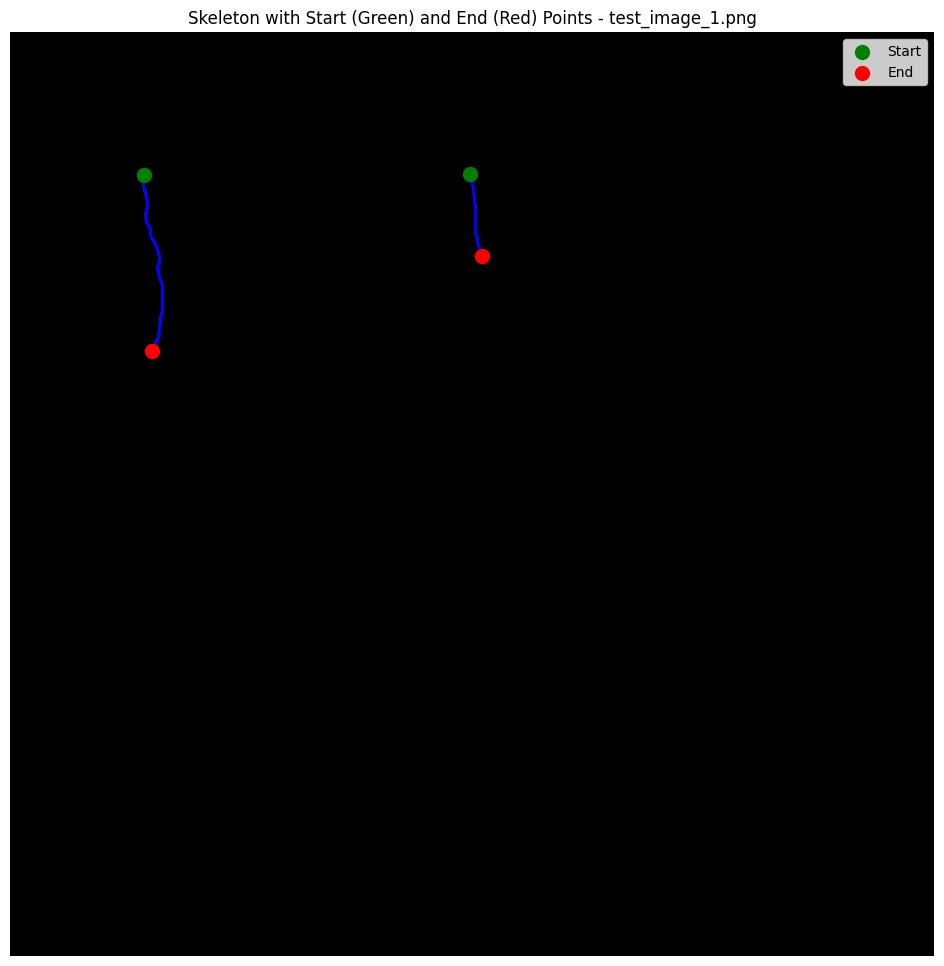

Visualizing components for test_image_10.png...
Component 1: Start (592, 387), End (1635, 268), Length: 1146.78
Component 2: Start (616, 876), End (2114, 594), Length: 1645.32
Component 3: Start (757, 1403), End (1946, 1327), Length: 1258.55
Component 4: Start (528, 1918), End (1756, 2004), Length: 1302.56
Component 5: Start (535, 2445), End (1606, 2523), Length: 1142.89


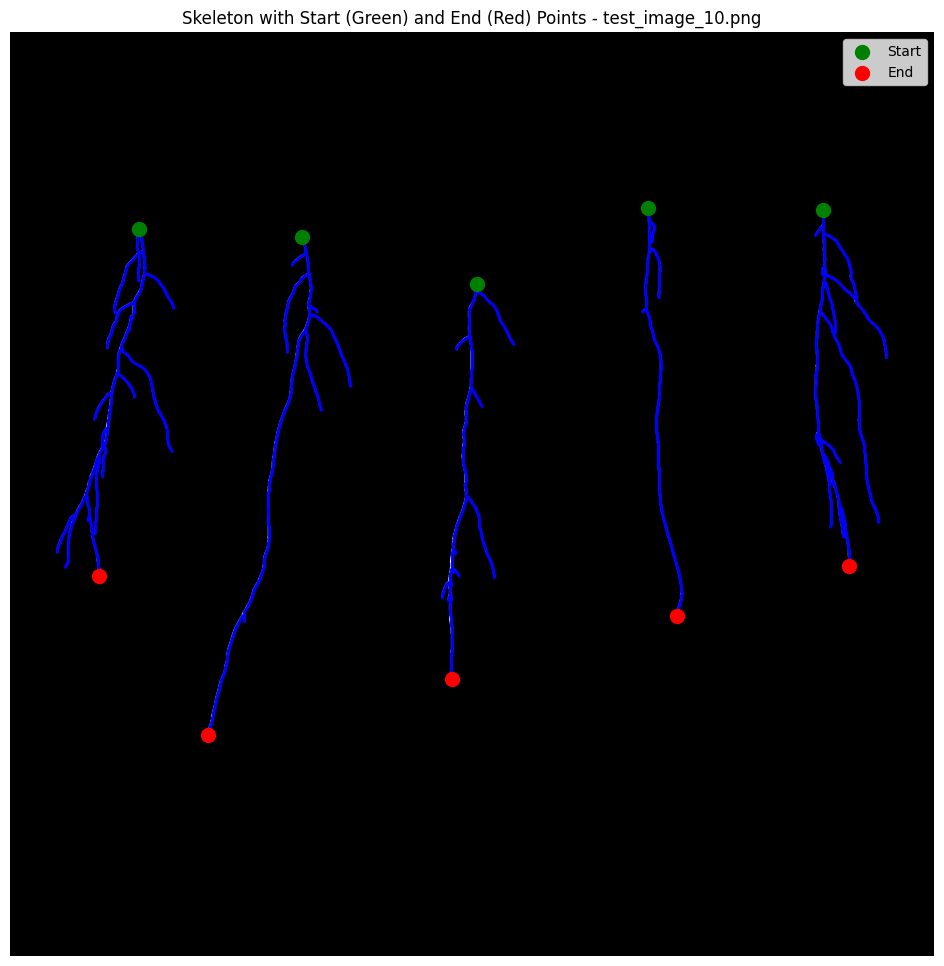

Visualizing components for test_image_11.png...
Component 1: Start (634, 360), End (1616, 156), Length: 1080.34
Component 2: Start (709, 816), End (2027, 639), Length: 1415.10
Component 3: Start (532, 1396), End (1891, 1298), Length: 1457.58
Component 4: Start (625, 1901), End (2074, 1902), Length: 1540.54
Component 5: Start (647, 2415), End (1759, 2220), Length: 1218.80


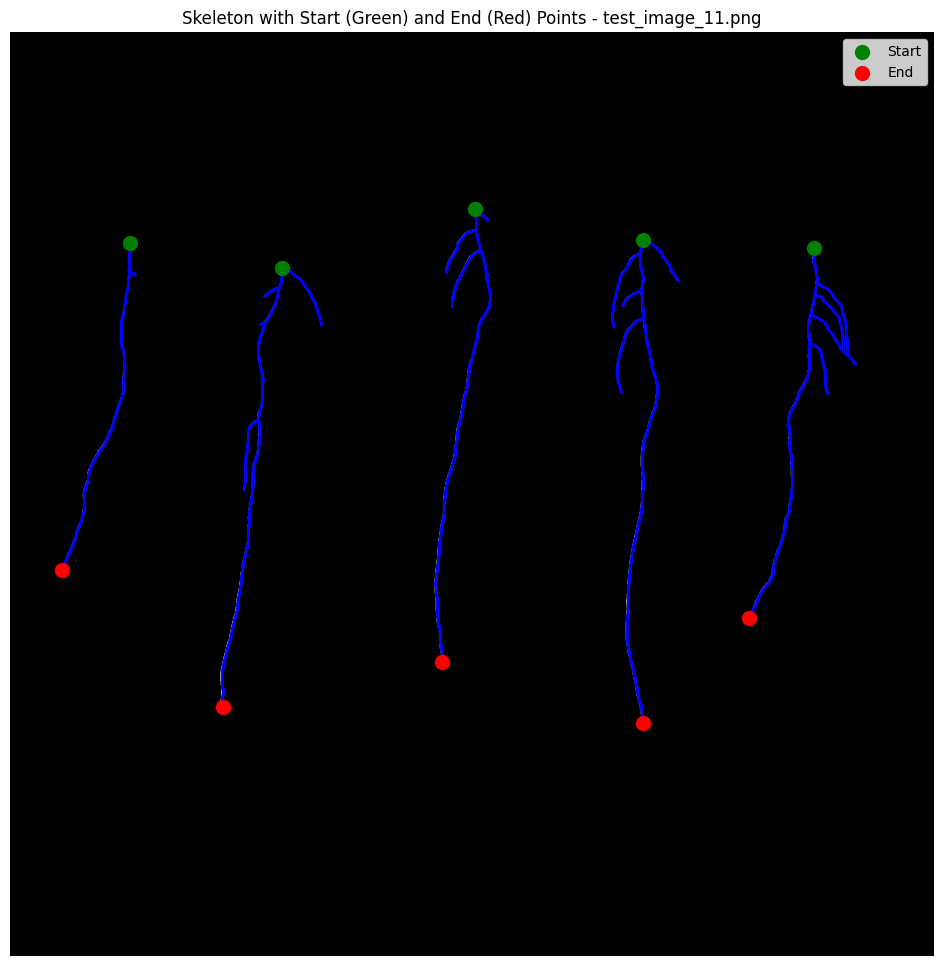

Visualizing components for test_image_12.png...
Component 1: Start (434, 365), End (1385, 439), Length: 1021.17
Component 2: Start (445, 894), End (1452, 834), Length: 1240.35
Component 3: Start (415, 1407), End (1288, 1375), Length: 932.99
Component 4: Start (397, 1902), End (1325, 1739), Length: 1005.46
Component 5: Start (385, 2429), End (1344, 2322), Length: 1024.86


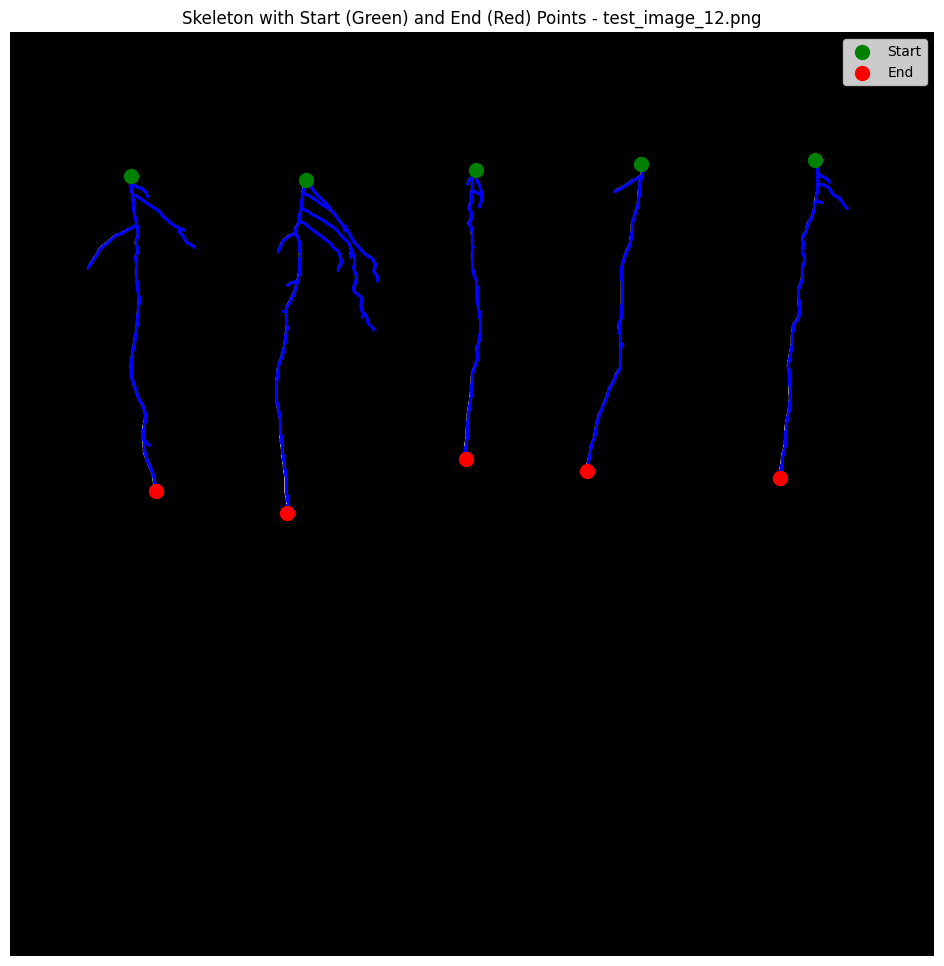

Visualizing components for test_image_13.png...
Component 1: Start (482, 376), End (1819, 344), Length: 1443.58
Component 2: Start (465, 878), End (1605, 912), Length: 1193.85
Component 3: Start (465, 1433), End (1517, 1305), Length: 1138.98
Component 4: Start (465, 1934), End (1739, 1945), Length: 1350.14
Component 5: Start (462, 2451), End (1893, 2304), Length: 1522.06


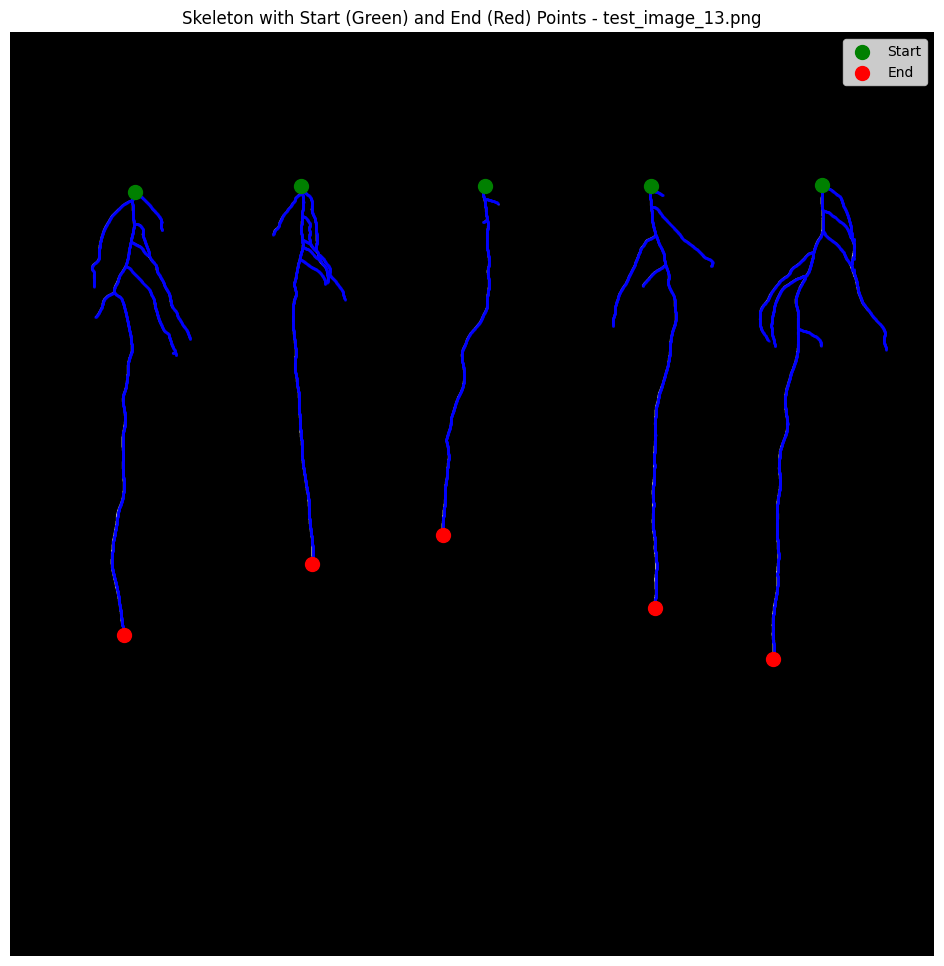

Visualizing components for test_image_14.png...
Component 1: Start (424, 873), End (557, 890), Length: 147.50
Component 2: Start (432, 1901), End (553, 1906), Length: 132.18


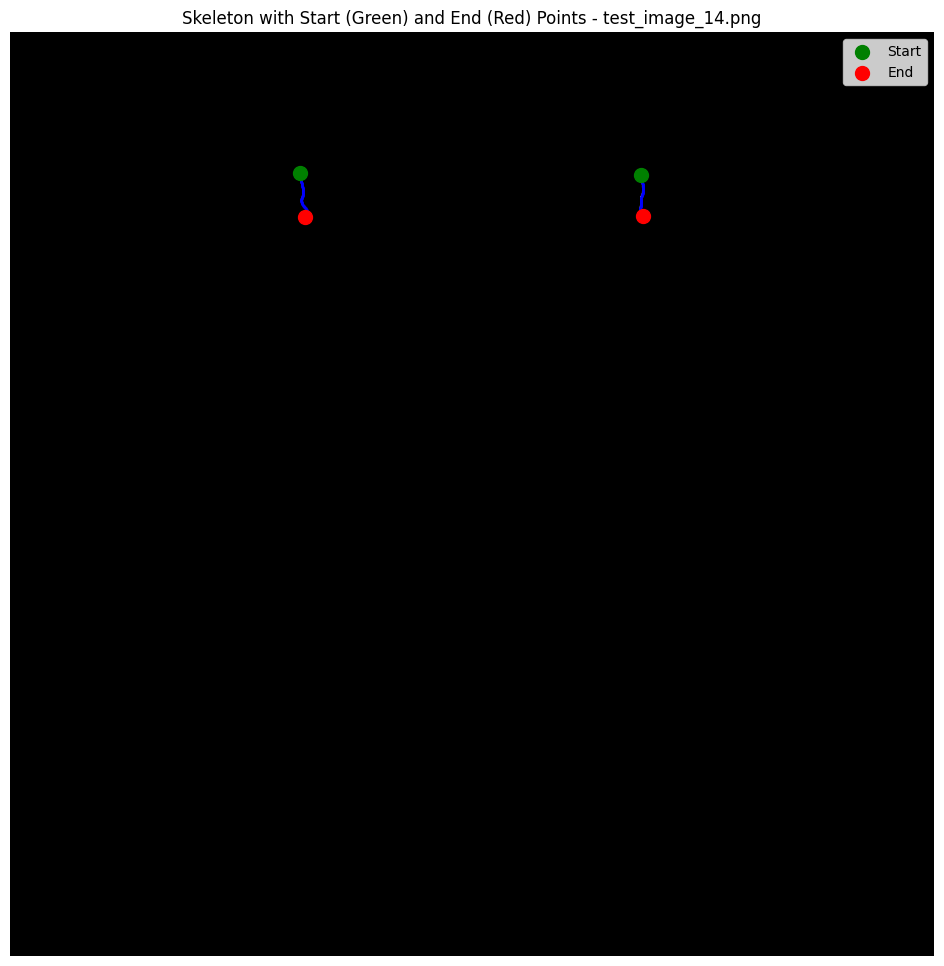

Visualizing components for test_image_15.png...
Component 1: Start (509, 385), End (794, 428), Length: 303.64
Component 2: Start (498, 908), End (769, 921), Length: 285.50
Component 3: Start (482, 1428), End (794, 1387), Length: 338.92
Component 4: Start (479, 1931), End (805, 1912), Length: 344.64
Component 5: Start (471, 2452), End (729, 2439), Length: 277.47


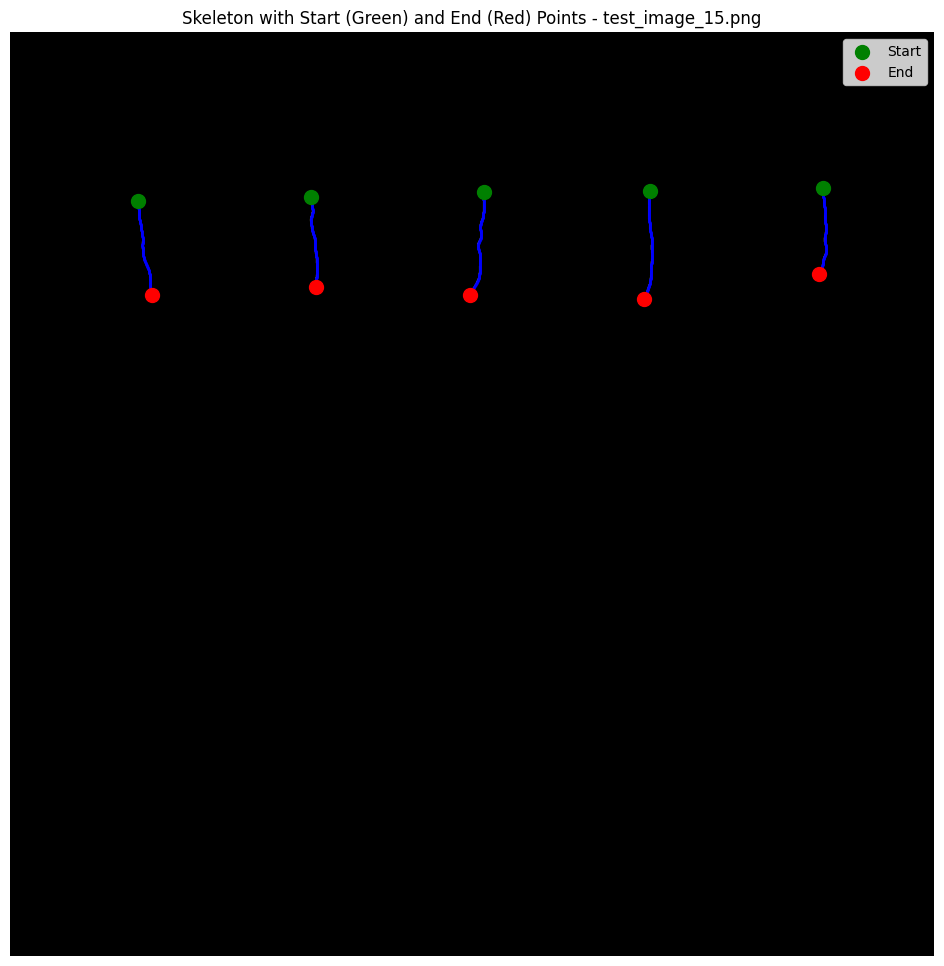

Visualizing components for test_image_16.png...
Component 1: Start (462, 379), End (828, 409), Length: 400.79
Component 2: Start (451, 907), End (819, 945), Length: 401.14
Component 3: Start (478, 1927), End (875, 1929), Length: 442.91
Component 4: Start (449, 2457), End (830, 2463), Length: 409.99


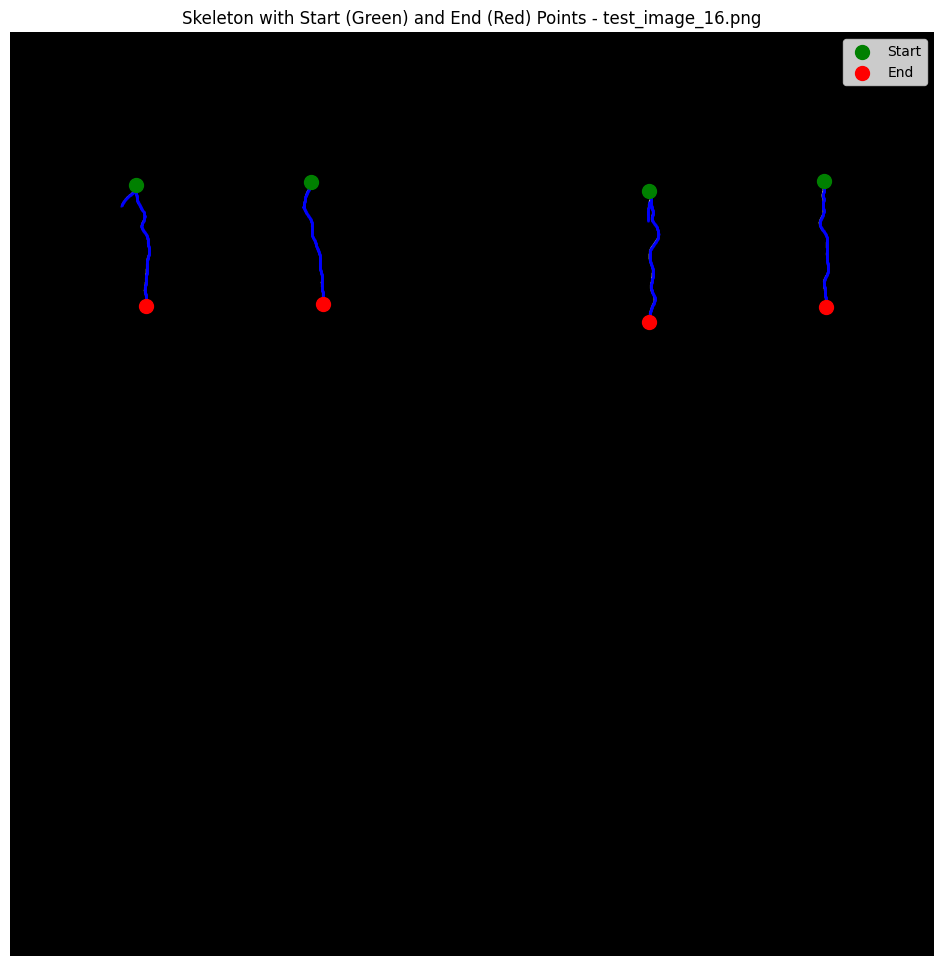

Visualizing components for test_image_17.png...
Component 1: Start (495, 386), End (1062, 293), Length: 624.58
Component 2: Start (487, 880), End (1119, 842), Length: 689.75
Component 3: Start (459, 1400), End (1191, 1368), Length: 778.25
Component 4: Start (423, 1907), End (1157, 1951), Length: 823.19
Component 5: Start (424, 2459), End (1113, 2314), Length: 770.72


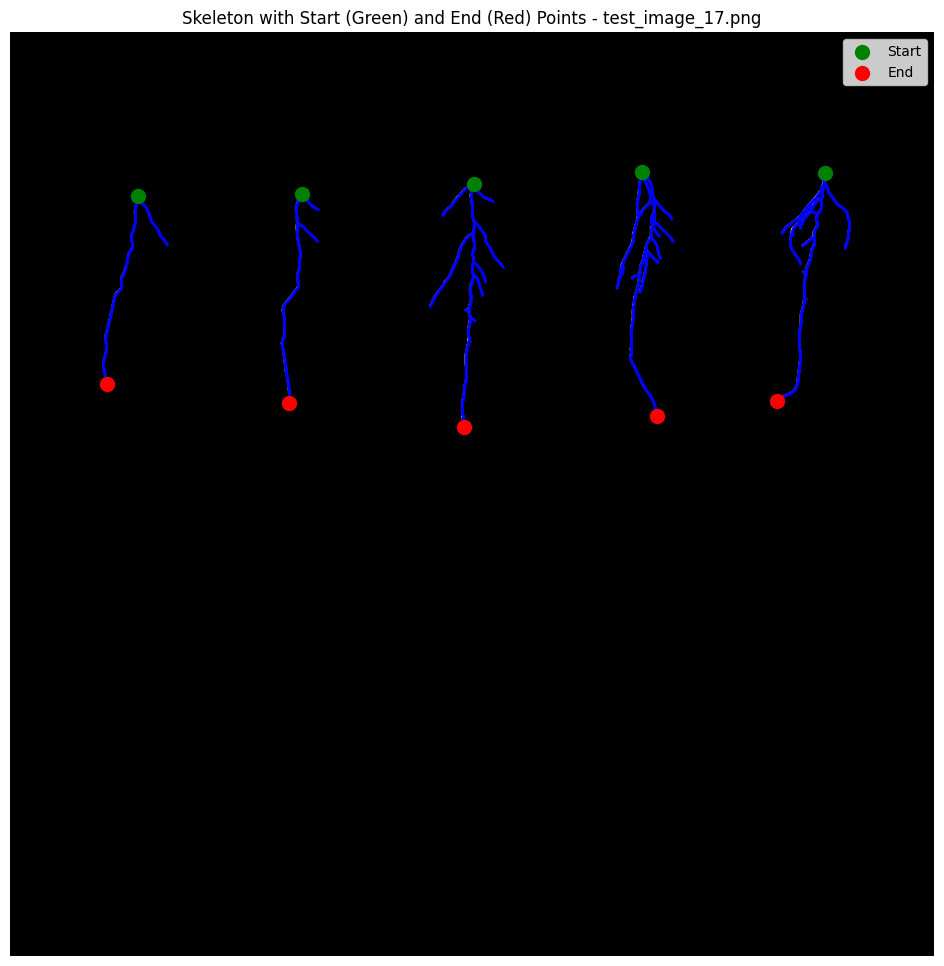

Visualizing components for test_image_18.png...
Component 1: Start (506, 383), End (1039, 297), Length: 622.00
Component 2: Start (467, 898), End (1505, 938), Length: 1152.52
Component 3: Start (541, 1958), End (1756, 1988), Length: 1592.80
Component 4: Start (464, 2416), End (1755, 2502), Length: 1622.18


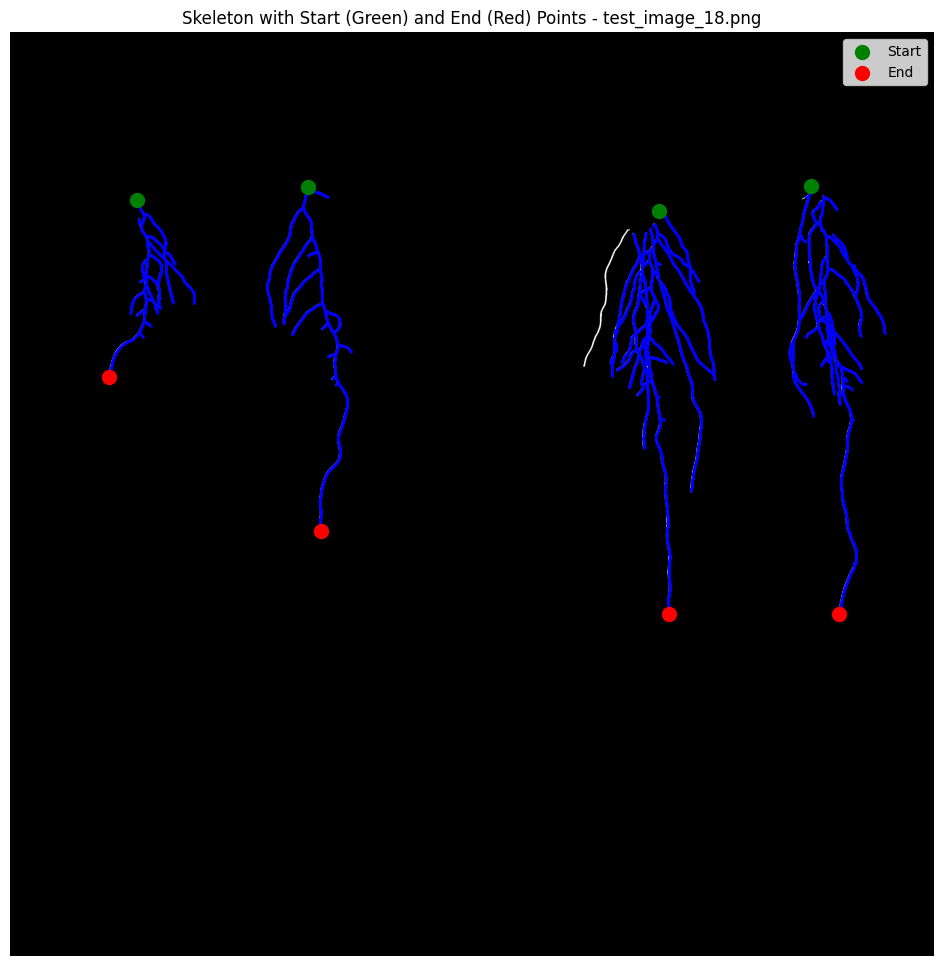

Visualizing components for test_image_2.png...
Component 1: Start (437, 316), End (1454, 103), Length: 1112.68
Component 2: Start (436, 827), End (544, 884), Length: 177.47
Component 3: Start (435, 1353), End (1267, 1233), Length: 909.93
Component 4: Start (476, 1902), End (1811, 1836), Length: 1510.39
Component 5: Start (459, 2358), End (1601, 2189), Length: 1228.09


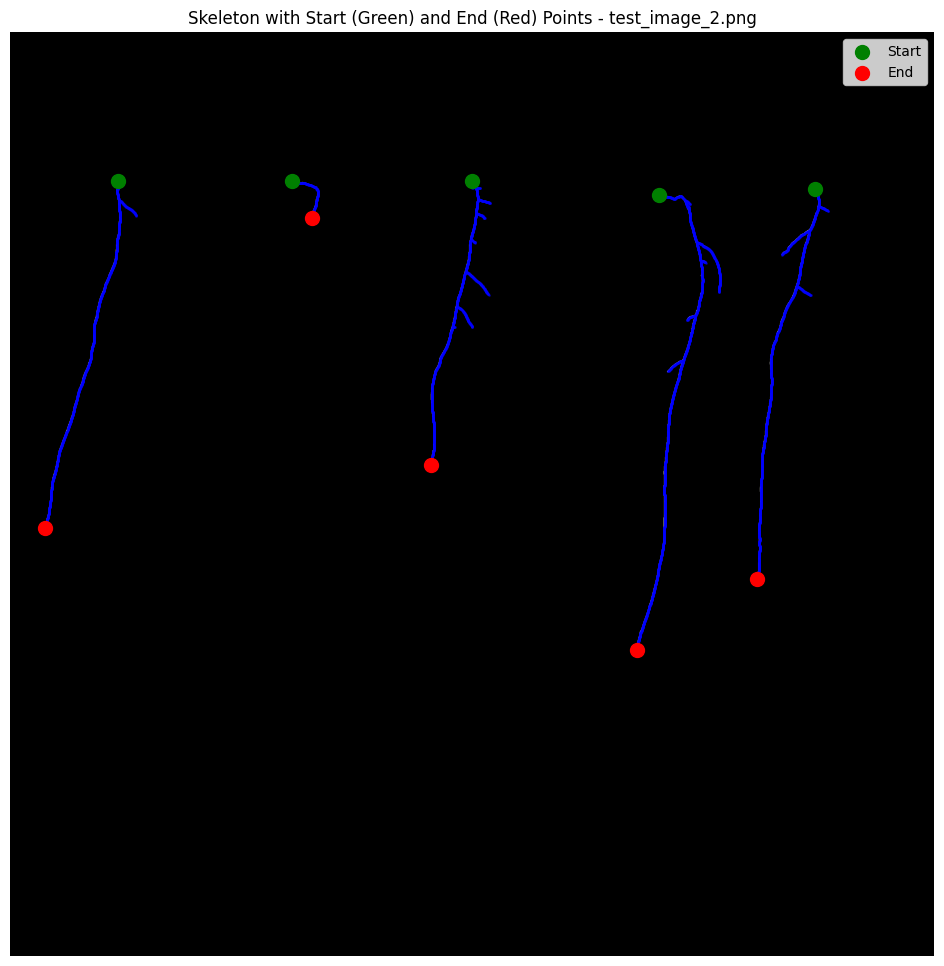

Visualizing components for test_image_3.png...
Component 1: Start (462, 379), End (596, 368), Length: 140.21
Component 2: Start (459, 895), End (476, 892), Length: 18.24
Component 3: Start (466, 1388), End (510, 1377), Length: 48.56
Component 4: Start (458, 1886), End (556, 1877), Length: 106.21
Component 5: Start (459, 2396), End (512, 2403), Length: 56.73


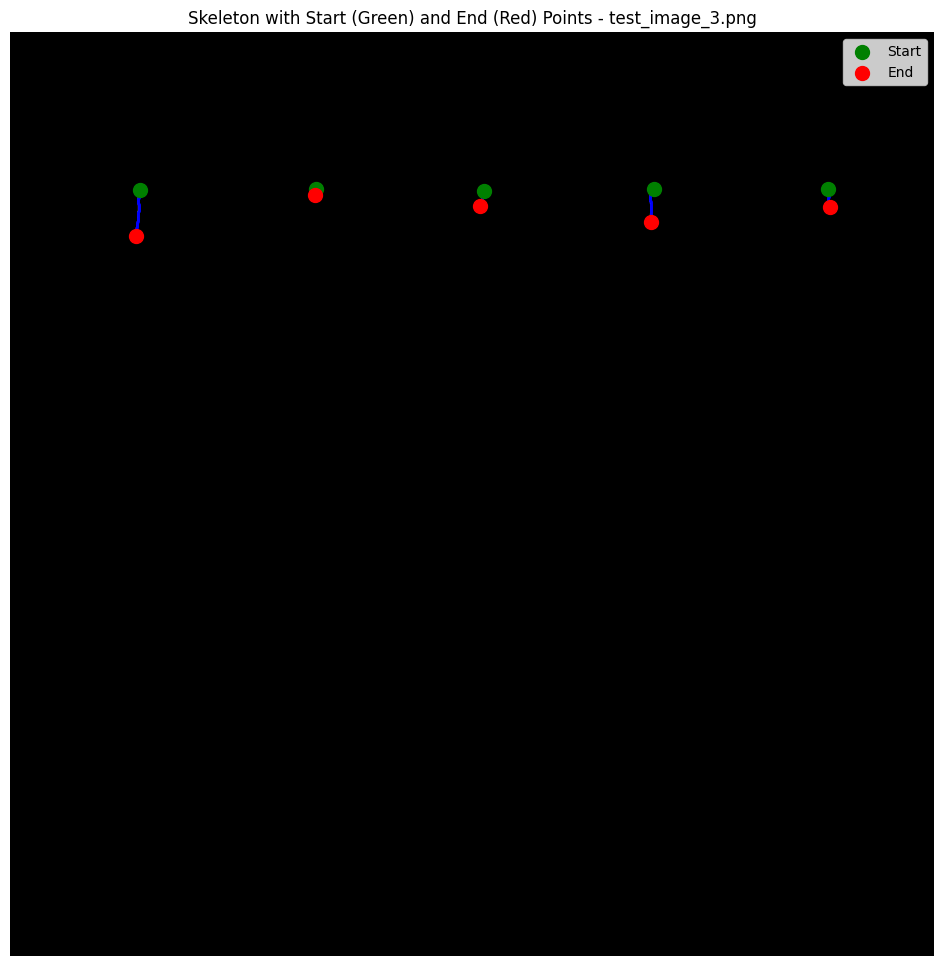

Visualizing components for test_image_4.png...
Component 1: Start (414, 376), End (749, 390), Length: 366.48
Component 2: Start (426, 885), End (733, 919), Length: 323.57
Component 3: Start (458, 1391), End (665, 1387), Length: 216.94
Component 4: Start (457, 1905), End (727, 1814), Length: 315.49
Component 5: Start (459, 2407), End (562, 2403), Length: 106.31


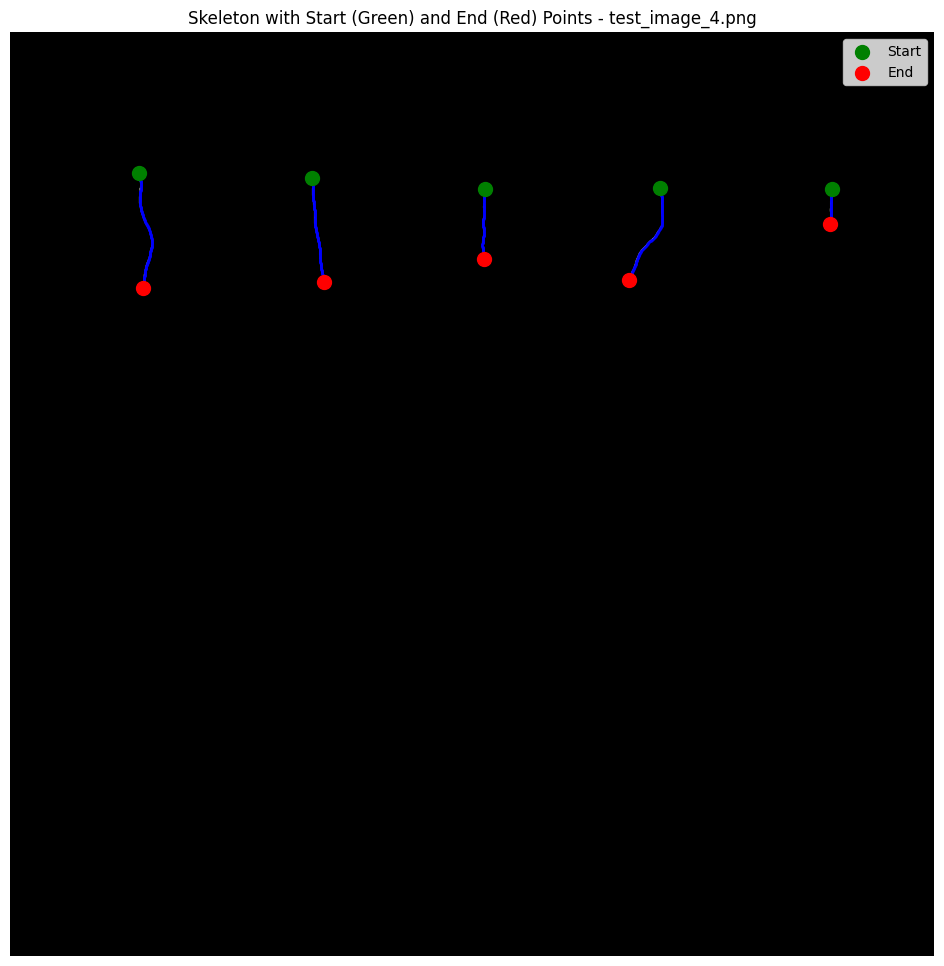

Visualizing components for test_image_5.png...
Component 1: Start (498, 358), End (744, 384), Length: 270.85
Component 2: Start (458, 868), End (686, 851), Length: 248.05
Component 3: Start (458, 1365), End (521, 1354), Length: 73.56
Component 4: Start (458, 1874), End (659, 1849), Length: 213.01
Component 5: Start (456, 2388), End (648, 2439), Length: 215.95


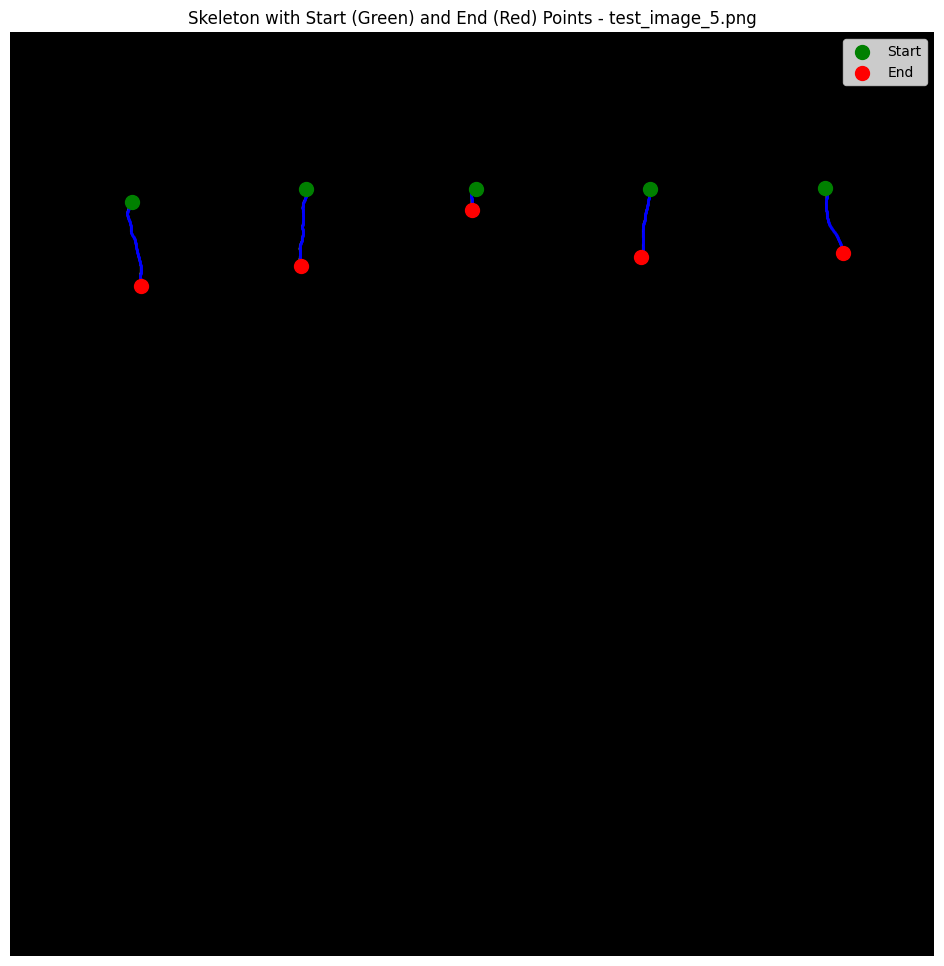

Visualizing components for test_image_6.png...
Component 1: Start (459, 356), End (753, 379), Length: 315.12
Component 2: Start (441, 841), End (906, 784), Length: 497.72
Component 3: Start (477, 1373), End (905, 1299), Length: 474.98
Component 4: Start (446, 1855), End (879, 1827), Length: 465.31
Component 5: Start (435, 2359), End (706, 2349), Length: 298.10


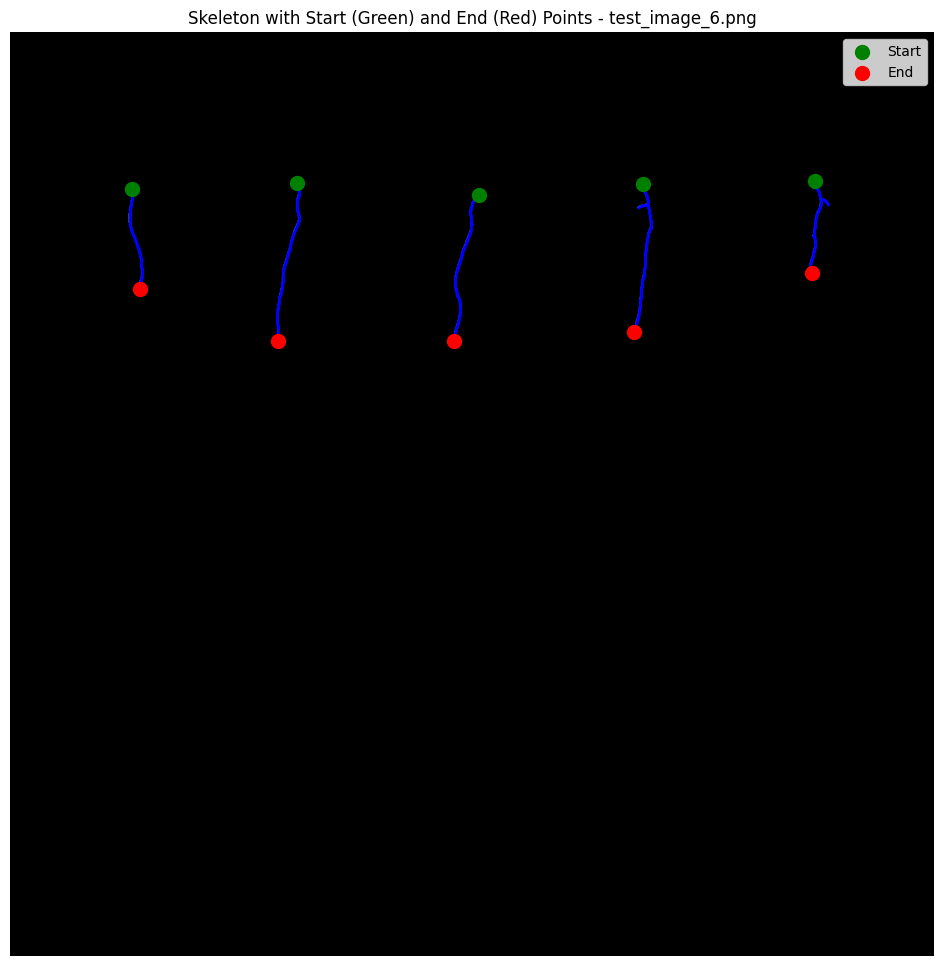

Visualizing components for test_image_7.png...
Component 1: Start (467, 342), End (853, 369), Length: 401.67
Component 2: Start (458, 836), End (634, 841), Length: 190.60
Component 3: Start (458, 1366), End (524, 1369), Length: 67.24
Component 4: Start (440, 1860), End (844, 1914), Length: 434.65
Component 5: Start (472, 2390), End (922, 2403), Length: 491.59


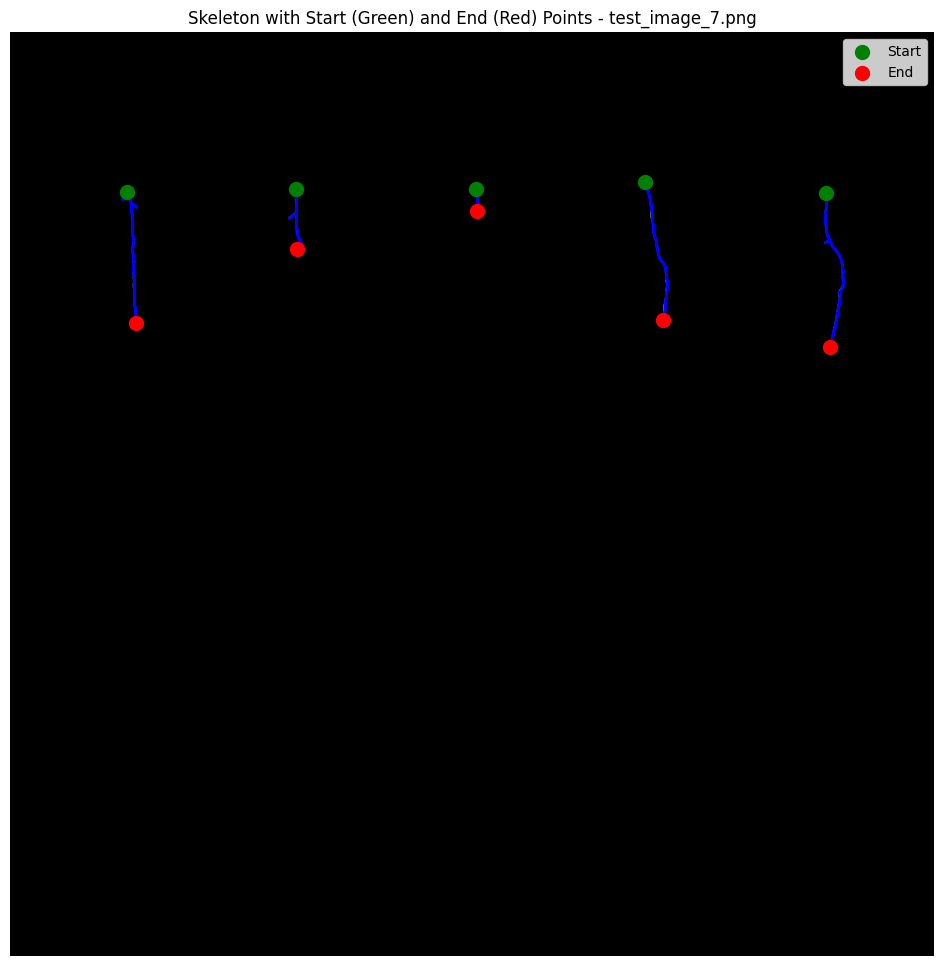

Visualizing components for test_image_8.png...
Component 1: Start (396, 379), End (2391, 159), Length: 2144.42
Component 2: Start (470, 888), End (2457, 549), Length: 2164.45
Component 3: Start (432, 1399), End (2496, 1340), Length: 2192.82
Component 4: Start (440, 1903), End (1682, 1623), Length: 1371.44
Component 5: Start (415, 2411), End (1095, 2391), Length: 715.97


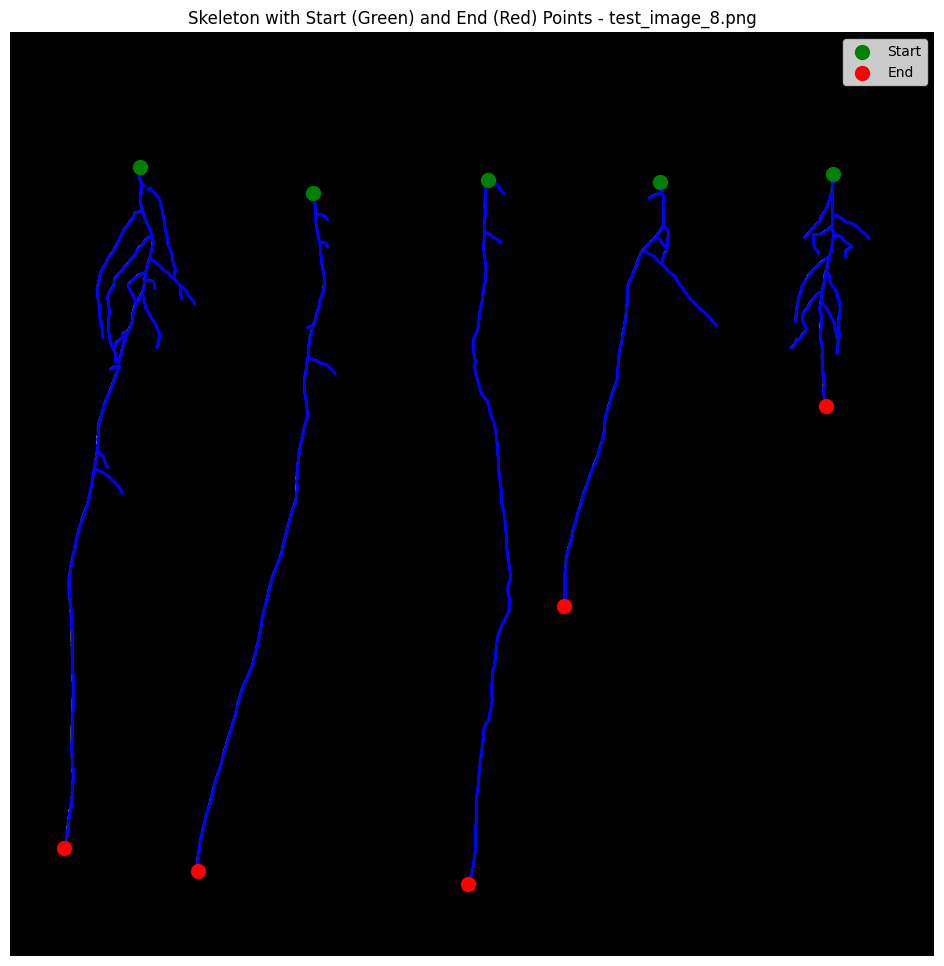

Visualizing components for test_image_9.png...
Component 1: Start (499, 399), End (1039, 432), Length: 586.18
Component 2: Start (470, 907), End (985, 883), Length: 537.37
Component 3: Start (499, 1443), End (1111, 1403), Length: 678.03
Component 4: Start (477, 1961), End (902, 1974), Length: 446.95
Component 5: Start (470, 2465), End (1087, 2456), Length: 666.05


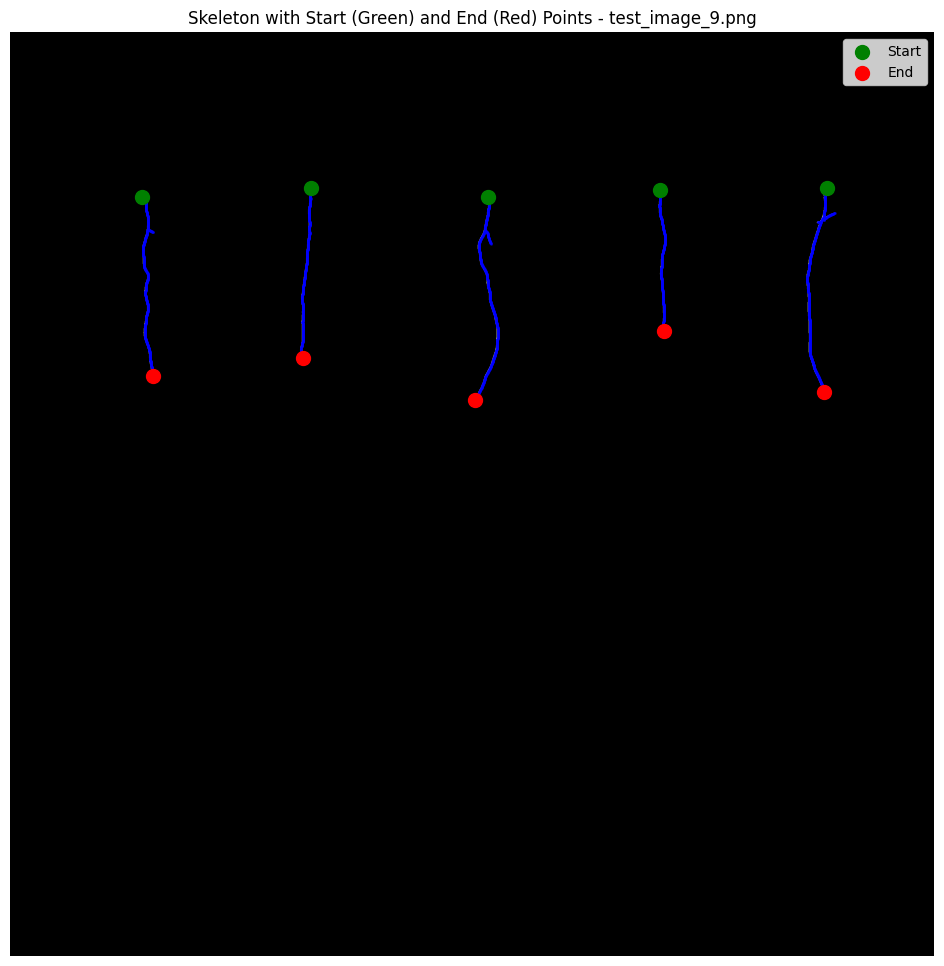

In [17]:
# Example usage

sectioned_bboxes = process_masks_and_extract_bboxes_vertical(filtered_masks, num_sections=5)
labeled_masks = create_single_component_labeled_mask_vertical(sectioned_bboxes, filtered_masks)
visualize_all_root_lengths(labeled_masks, filtered_masks)


In [18]:
# Step 1: Process masks into vertical sections
sectioned_bboxes = process_masks_and_extract_bboxes_vertical(processed_masks, num_sections=5)

# Step 2: Create labeled masks
labeled_masks = create_single_component_labeled_mask_vertical(sectioned_bboxes, filtered_masks)

# Step 3: Calculate root lengths and save to CSV
calculate_and_save_root_lengths_vertical(labeled_masks, filtered_masks, output_path)


Processing mask for test_image_1.png...
Processing mask for test_image_10.png...
Processing mask for test_image_11.png...
Processing mask for test_image_12.png...
Processing mask for test_image_13.png...
Processing mask for test_image_14.png...
Processing mask for test_image_15.png...
Processing mask for test_image_16.png...
Processing mask for test_image_17.png...
Processing mask for test_image_18.png...
Processing mask for test_image_2.png...
Processing mask for test_image_3.png...
Processing mask for test_image_4.png...
Processing mask for test_image_5.png...
Processing mask for test_image_6.png...
Processing mask for test_image_7.png...
Processing mask for test_image_8.png...
Processing mask for test_image_9.png...
Creating labeled mask for test_image_1.png...
Labeled mask created for test_image_1.png.
Creating labeled mask for test_image_10.png...
Labeled mask created for test_image_10.png.
Creating labeled mask for test_image_11.png...
Labeled mask created for test_image_11.png.
